In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools

import IPython
import IPython.display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize': (16., 12.)})

In [2]:
df = pd.read_excel('./countries_gas.xlsx', index_col=0)

In [3]:
df

USA  Japan,South Korea    Eupora
Date                                             
1984-01-01  59191.20            3158.67  33524.59
1984-02-01  49898.24            2902.67  32041.52
1984-03-01  53440.16            3397.67  30465.52
1984-04-01  41004.24            3065.67  23029.52
1984-05-01  35196.24            2932.67  19727.56
...              ...                ...       ...
2020-08-01  65728.00           12880.00  28154.50
2020-09-01  57408.00           11753.00  32761.60
2020-10-01  61568.00           12075.00  37880.60
2020-11-01  65728.00           13685.00  49142.40
2020-12-01  86528.00           15617.00  57844.70

[444 rows x 3 columns]

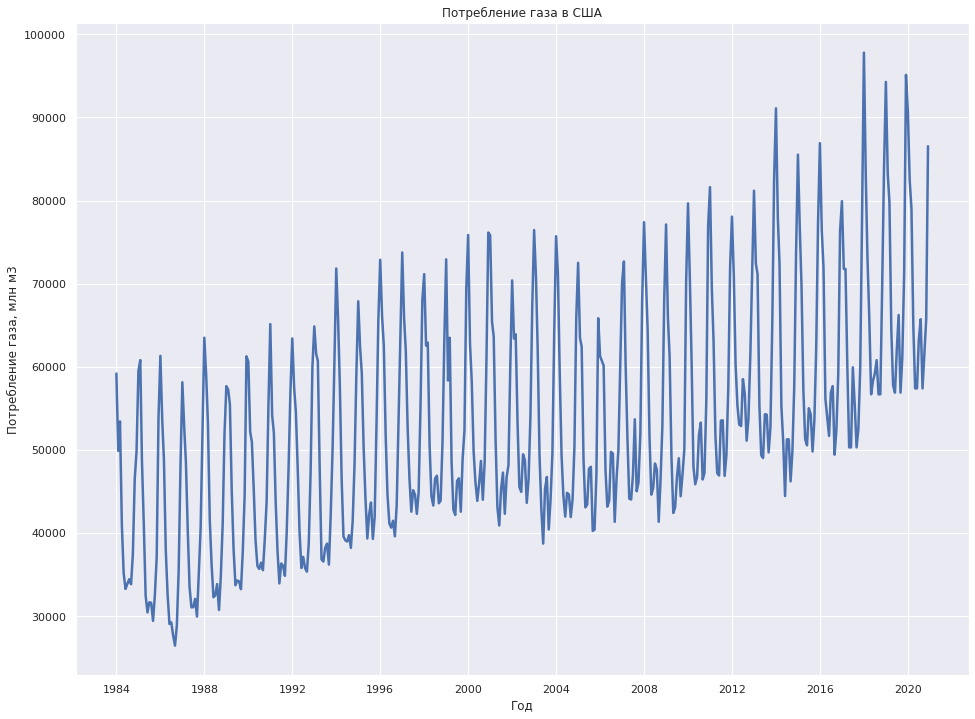

In [4]:
ax = sns.lineplot(data=df['USA'], palette='tab10', linewidth=2.5)
ax.set(xlabel='Год', ylabel='Потребление газа, млн м3', title='Потребление газа в США')
plt.show()

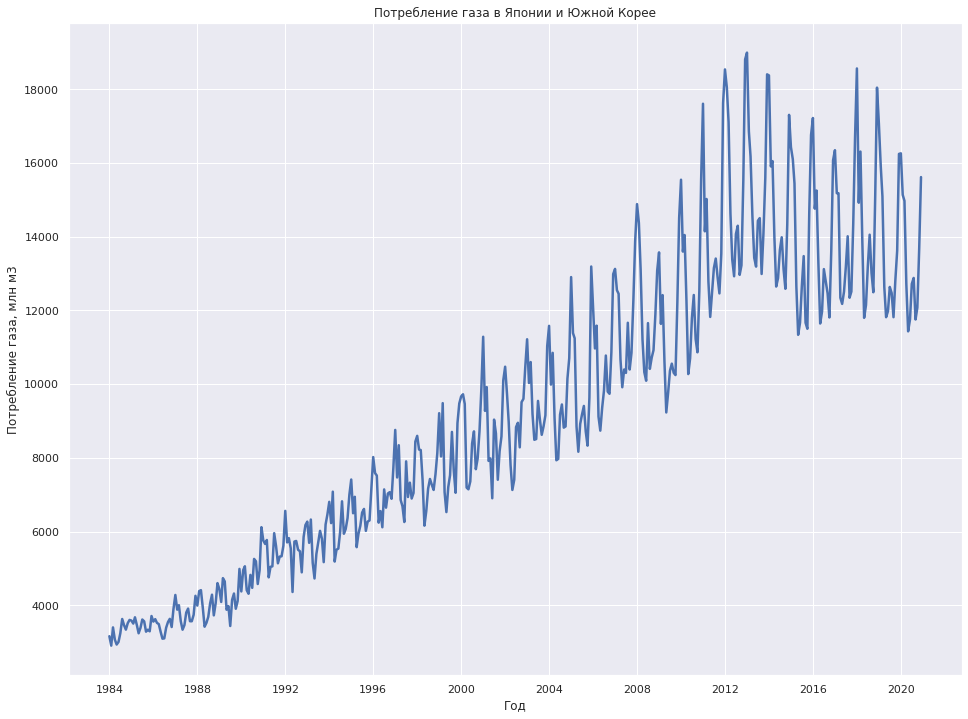

In [5]:
ax = sns.lineplot(data=df['Japan,South Korea'], palette='tab10', linewidth=2.5)
ax.set(xlabel='Год', ylabel='Потребление газа, млн м3', title='Потребление газа в Японии и Южной Корее')
plt.show()

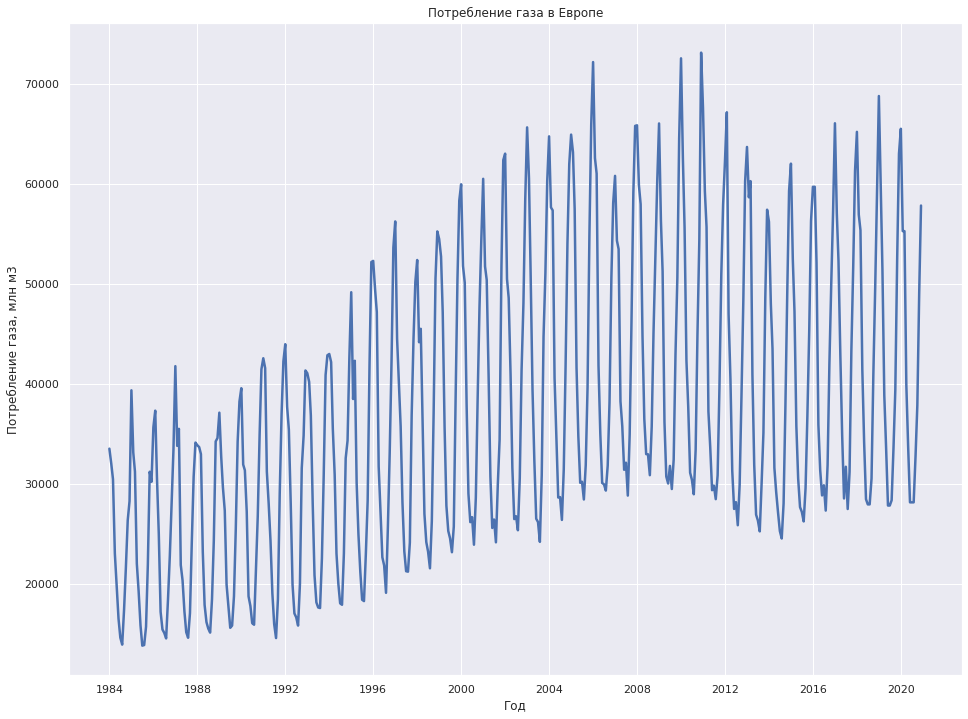

In [6]:
ax = sns.lineplot(data=df['Eupora'], palette='tab10', linewidth=2.5)
ax.set(xlabel='Год', ylabel='Потребление газа, млн м3', title='Потребление газа в Европе')
plt.show()

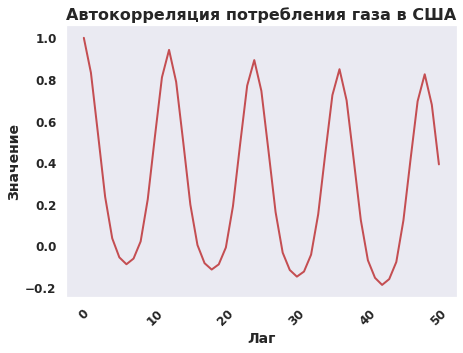

In [7]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(df['USA'],
                                                             adjusted=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha=0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Автокорреляция потребления газа в США', weight='bold', fontsize=16)
plt.xlabel('Лаг', weight='bold', fontsize=14)
plt.ylabel('Значение', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)


In [8]:
# timestamp_s = df.index.map(pd.Timestamp.timestamp)


In [9]:
# months = 

In [10]:
# day = 24*60*60
# month = 
# year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


# Модели

In [11]:
split_index = int(df.shape[0] * 0.8)

series = df['USA'].values
train_data = df['USA'][:split_index].values
test_data = df['USA'][split_index:].values

time_train = df['USA'][:split_index].index
time_test = df.index.values[split_index:]
x_valid = df['USA'][split_index:].values

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
window_size = 12
batch_size = 8
shuffle_buffer_size = 1000

dataset = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)
validation_ds = windowed_dataset(test_data, window_size, batch_size, shuffle_buffer_size)

In [15]:
list(dataset.take(1).as_numpy_iterator())

[(array([[72676.17, 60276.17, 51255.17, 44152.17, 44043.17, 47005.17,
          53691.17, 45041.17, 46096.17, 51947.17, 67926.17, 77392.42],
         [30472.  , 31690.  , 31633.  , 29452.  , 32483.  , 37157.  ,
          53871.  , 61321.76, 53558.72, 48826.72, 37892.8 , 32623.76],
         [48457.44, 61213.44, 76153.44, 75809.17, 65408.17, 63630.17,
          51193.17, 43133.17, 40926.17, 45275.17, 47288.17, 42334.17],
         [52879.68, 58529.76, 56729.76, 51120.8 , 53834.72, 61377.76,
          70995.68, 81176.8 , 72442.72, 71138.72, 55317.76, 49369.76],
         [49651.17, 64084.17, 75705.76, 71047.68, 59442.72, 49381.76,
          44514.72, 41990.72, 44851.68, 44655.68, 41943.68, 44062.72],
         [62224.17, 49365.17, 42889.17, 38748.17, 45316.17, 46762.17,
          40451.17, 43978.17, 49651.17, 64084.17, 75705.76, 71047.68],
         [30770.67, 34820.67, 41049.67, 51866.67, 57680.16, 57244.16,
          55494.24, 44958.24, 38096.24, 33743.2 , 34315.2 , 34199.2 ],
         [463

In [16]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
history = model.fit(dataset,
                    validation_data=validation_ds,
                    epochs=1000, verbose=1)

Epoch 1/1000
43/43 [==============================] - 3s 20ms/step - loss: 172420352.0000 - val_loss: 272014816.0000
Epoch 2/1000
43/43 [==============================] - 0s 2ms/step - loss: 173703594.5455 - val_loss: 259273952.0000
Epoch 3/1000
43/43 [==============================] - 0s 2ms/step - loss: 172060979.6364 - val_loss: 236394336.0000
Epoch 4/1000
43/43 [==============================] - 0s 2ms/step - loss: 151255734.5455 - val_loss: 221953504.0000
Epoch 5/1000
43/43 [==============================] - 0s 2ms/step - loss: 142993633.8182 - val_loss: 208807536.0000
Epoch 6/1000
43/43 [==============================] - 0s 2ms/step - loss: 122786808.9091 - val_loss: 199105648.0000
Epoch 7/1000
43/43 [==============================] - 0s 2ms/step - loss: 130861406.7273 - val_loss: 185797536.0000
Epoch 8/1000
43/43 [==============================] - 0s 3ms/step - loss: 120525266.1818 - val_loss: 176175072.0000
Epoch 9/1000
43/43 [==============================] - 0s 2ms/step - los

43/43 [==============================] - 0s 2ms/step - loss: 15400740.2500 - val_loss: 26152970.0000
Epoch 73/1000
43/43 [==============================] - 0s 2ms/step - loss: 14337110.8068 - val_loss: 26266948.0000
Epoch 74/1000
43/43 [==============================] - 0s 2ms/step - loss: 17740923.7273 - val_loss: 25863918.0000
Epoch 75/1000
43/43 [==============================] - 0s 2ms/step - loss: 15033917.3409 - val_loss: 25993380.0000
Epoch 76/1000
43/43 [==============================] - 0s 2ms/step - loss: 16305315.4318 - val_loss: 25557066.0000
Epoch 77/1000
43/43 [==============================] - 0s 3ms/step - loss: 15159315.2727 - val_loss: 26948948.0000
Epoch 78/1000
43/43 [==============================] - 0s 2ms/step - loss: 16855109.2045 - val_loss: 24225494.0000
Epoch 79/1000
43/43 [==============================] - 0s 3ms/step - loss: 14252773.0455 - val_loss: 24050626.0000
Epoch 80/1000
43/43 [==============================] - 0s 2ms/step - loss: 12368524.3068 - val

Epoch 143/1000
43/43 [==============================] - 0s 2ms/step - loss: 13998315.0455 - val_loss: 21005946.0000
Epoch 144/1000
43/43 [==============================] - 0s 2ms/step - loss: 12143054.4545 - val_loss: 22172136.0000
Epoch 145/1000
43/43 [==============================] - 0s 2ms/step - loss: 12362726.5909 - val_loss: 21702542.0000
Epoch 146/1000
43/43 [==============================] - 0s 2ms/step - loss: 12976890.0000 - val_loss: 20454996.0000
Epoch 147/1000
43/43 [==============================] - 0s 2ms/step - loss: 12516671.5682 - val_loss: 20444322.0000
Epoch 148/1000
43/43 [==============================] - 0s 2ms/step - loss: 11399113.5000 - val_loss: 20368290.0000
Epoch 149/1000
43/43 [==============================] - 0s 2ms/step - loss: 12382130.7045 - val_loss: 26119128.0000
Epoch 150/1000
43/43 [==============================] - 0s 2ms/step - loss: 11552126.7727 - val_loss: 20533076.0000
Epoch 151/1000
43/43 [==============================] - 0s 2ms/step - lo

43/43 [==============================] - 0s 3ms/step - loss: 11385799.8750 - val_loss: 19173692.0000
Epoch 214/1000
43/43 [==============================] - 0s 3ms/step - loss: 11848972.6591 - val_loss: 20563848.0000
Epoch 215/1000
43/43 [==============================] - 0s 3ms/step - loss: 10736737.3977 - val_loss: 18894220.0000
Epoch 216/1000
43/43 [==============================] - 0s 3ms/step - loss: 10635078.4886 - val_loss: 19440168.0000
Epoch 217/1000
43/43 [==============================] - 0s 3ms/step - loss: 11380896.7273 - val_loss: 18916348.0000
Epoch 218/1000
43/43 [==============================] - 0s 3ms/step - loss: 10588416.9091 - val_loss: 18545186.0000
Epoch 219/1000
43/43 [==============================] - 0s 2ms/step - loss: 10853650.2500 - val_loss: 19057412.0000
Epoch 220/1000
43/43 [==============================] - 0s 2ms/step - loss: 12111978.5000 - val_loss: 18492858.0000
Epoch 221/1000
43/43 [==============================] - 0s 2ms/step - loss: 12402097.02

Epoch 284/1000
43/43 [==============================] - 0s 2ms/step - loss: 9082660.8693 - val_loss: 17417412.0000
Epoch 285/1000
43/43 [==============================] - 0s 2ms/step - loss: 9416174.0568 - val_loss: 17735924.0000
Epoch 286/1000
43/43 [==============================] - 0s 2ms/step - loss: 9544222.7159 - val_loss: 17334948.0000
Epoch 287/1000
43/43 [==============================] - 0s 2ms/step - loss: 11874768.9886 - val_loss: 17360150.0000
Epoch 288/1000
43/43 [==============================] - 0s 2ms/step - loss: 9821779.1705 - val_loss: 17336580.0000
Epoch 289/1000
43/43 [==============================] - 0s 2ms/step - loss: 9026255.1932 - val_loss: 17283426.0000
Epoch 290/1000
43/43 [==============================] - 0s 2ms/step - loss: 10862715.2727 - val_loss: 17291306.0000
Epoch 291/1000
43/43 [==============================] - 0s 2ms/step - loss: 10143466.9205 - val_loss: 17669428.0000
Epoch 292/1000
43/43 [==============================] - 0s 2ms/step - loss: 1

Epoch 355/1000
43/43 [==============================] - 0s 2ms/step - loss: 12613822.6364 - val_loss: 17968320.0000
Epoch 356/1000
43/43 [==============================] - 0s 2ms/step - loss: 10727948.0682 - val_loss: 17697190.0000
Epoch 357/1000
43/43 [==============================] - 0s 3ms/step - loss: 10675632.6818 - val_loss: 18475396.0000
Epoch 358/1000
43/43 [==============================] - 0s 2ms/step - loss: 9945269.1932 - val_loss: 17693394.0000
Epoch 359/1000
43/43 [==============================] - 0s 3ms/step - loss: 9249109.3068 - val_loss: 16998376.0000
Epoch 360/1000
43/43 [==============================] - 0s 3ms/step - loss: 11394432.0909 - val_loss: 17024700.0000
Epoch 361/1000
43/43 [==============================] - 0s 2ms/step - loss: 10008511.3523 - val_loss: 16569849.0000
Epoch 362/1000
43/43 [==============================] - 0s 2ms/step - loss: 8779409.9205 - val_loss: 16513574.0000
Epoch 363/1000
43/43 [==============================] - 0s 2ms/step - loss:

Epoch 426/1000
43/43 [==============================] - 0s 3ms/step - loss: 12219158.3636 - val_loss: 16059778.0000
Epoch 427/1000
43/43 [==============================] - 0s 3ms/step - loss: 9315926.7557 - val_loss: 17925074.0000
Epoch 428/1000
43/43 [==============================] - 0s 3ms/step - loss: 9706820.8182 - val_loss: 16236403.0000
Epoch 429/1000
43/43 [==============================] - 0s 3ms/step - loss: 11246216.9091 - val_loss: 16962264.0000
Epoch 430/1000
43/43 [==============================] - 0s 3ms/step - loss: 8142791.1960 - val_loss: 16995246.0000
Epoch 431/1000
43/43 [==============================] - 0s 2ms/step - loss: 9034663.7500 - val_loss: 15985441.0000
Epoch 432/1000
43/43 [==============================] - 0s 2ms/step - loss: 9858872.3295 - val_loss: 16045423.0000
Epoch 433/1000
43/43 [==============================] - 0s 2ms/step - loss: 9882823.9205 - val_loss: 16106867.0000
Epoch 434/1000
43/43 [==============================] - 0s 3ms/step - loss: 88

43/43 [==============================] - 0s 3ms/step - loss: 10596099.2841 - val_loss: 16221279.0000
Epoch 498/1000
43/43 [==============================] - 0s 3ms/step - loss: 10325488.3182 - val_loss: 15883055.0000
Epoch 499/1000
43/43 [==============================] - 0s 3ms/step - loss: 11187689.5455 - val_loss: 15788993.0000
Epoch 500/1000
43/43 [==============================] - 0s 2ms/step - loss: 10005049.3636 - val_loss: 15757756.0000
Epoch 501/1000
43/43 [==============================] - 0s 2ms/step - loss: 8272319.3750 - val_loss: 15843112.0000
Epoch 502/1000
43/43 [==============================] - 0s 2ms/step - loss: 9227767.0568 - val_loss: 15964582.0000
Epoch 503/1000
43/43 [==============================] - 0s 2ms/step - loss: 8678086.1023 - val_loss: 15710823.0000
Epoch 504/1000
43/43 [==============================] - 0s 2ms/step - loss: 8396862.6136 - val_loss: 17192846.0000
Epoch 505/1000
43/43 [==============================] - 0s 2ms/step - loss: 12549572.2955 -

43/43 [==============================] - 0s 3ms/step - loss: 10033127.9545 - val_loss: 15403826.0000
Epoch 569/1000
43/43 [==============================] - 0s 2ms/step - loss: 8864190.3977 - val_loss: 15604766.0000
Epoch 570/1000
43/43 [==============================] - 0s 2ms/step - loss: 9471290.3977 - val_loss: 15934512.0000
Epoch 571/1000
43/43 [==============================] - 0s 2ms/step - loss: 9133996.6932 - val_loss: 15653886.0000
Epoch 572/1000
43/43 [==============================] - 0s 2ms/step - loss: 8913250.2273 - val_loss: 16332667.0000
Epoch 573/1000
43/43 [==============================] - 0s 2ms/step - loss: 8730942.4773 - val_loss: 15492372.0000
Epoch 574/1000
43/43 [==============================] - 0s 2ms/step - loss: 8273499.5455 - val_loss: 16194023.0000
Epoch 575/1000
43/43 [==============================] - 0s 2ms/step - loss: 11674710.2955 - val_loss: 15469137.0000
Epoch 576/1000
43/43 [==============================] - 0s 2ms/step - loss: 9400122.7898 - va

43/43 [==============================] - 0s 2ms/step - loss: 8721183.3636 - val_loss: 15495449.0000
Epoch 640/1000
43/43 [==============================] - 0s 2ms/step - loss: 8408496.1250 - val_loss: 15282661.0000
Epoch 641/1000
43/43 [==============================] - 0s 2ms/step - loss: 8861779.4318 - val_loss: 15309191.0000
Epoch 642/1000
43/43 [==============================] - 0s 2ms/step - loss: 8177157.5114 - val_loss: 15681426.0000
Epoch 643/1000
43/43 [==============================] - 0s 2ms/step - loss: 9808028.8182 - val_loss: 15312698.0000
Epoch 644/1000
43/43 [==============================] - 0s 3ms/step - loss: 9151485.4773 - val_loss: 15282370.0000
Epoch 645/1000
43/43 [==============================] - 0s 3ms/step - loss: 8808158.4091 - val_loss: 15383954.0000
Epoch 646/1000
43/43 [==============================] - 0s 3ms/step - loss: 11023319.2045 - val_loss: 15777327.0000
Epoch 647/1000
43/43 [==============================] - 0s 3ms/step - loss: 9412786.0682 - val

43/43 [==============================] - 0s 3ms/step - loss: 8923072.0682 - val_loss: 15278629.0000
Epoch 711/1000
43/43 [==============================] - 0s 3ms/step - loss: 9340235.5227 - val_loss: 15569337.0000
Epoch 712/1000
43/43 [==============================] - 0s 3ms/step - loss: 9469304.1364 - val_loss: 15307874.0000
Epoch 713/1000
43/43 [==============================] - 0s 2ms/step - loss: 10312181.6023 - val_loss: 15267970.0000
Epoch 714/1000
43/43 [==============================] - 0s 2ms/step - loss: 9211402.1023 - val_loss: 15158011.0000
Epoch 715/1000
43/43 [==============================] - 0s 2ms/step - loss: 8867949.4602 - val_loss: 15309322.0000
Epoch 716/1000
43/43 [==============================] - 0s 3ms/step - loss: 8049698.3295 - val_loss: 15215882.0000
Epoch 717/1000
43/43 [==============================] - 0s 4ms/step - loss: 9388053.7159 - val_loss: 15833286.0000
Epoch 718/1000
43/43 [==============================] - 0s 3ms/step - loss: 8412009.7614 - val

43/43 [==============================] - 0s 2ms/step - loss: 8958117.1023 - val_loss: 15115713.0000
Epoch 782/1000
43/43 [==============================] - 0s 2ms/step - loss: 10014806.1136 - val_loss: 15926683.0000
Epoch 783/1000
43/43 [==============================] - 0s 2ms/step - loss: 8838779.5909 - val_loss: 15446847.0000
Epoch 784/1000
43/43 [==============================] - 0s 2ms/step - loss: 10053181.3409 - val_loss: 16104325.0000
Epoch 785/1000
43/43 [==============================] - 0s 2ms/step - loss: 9258902.3750 - val_loss: 15118417.0000
Epoch 786/1000
43/43 [==============================] - 0s 2ms/step - loss: 9288698.3409 - val_loss: 15082215.0000
Epoch 787/1000
43/43 [==============================] - 0s 2ms/step - loss: 8319270.1591 - val_loss: 15378912.0000
Epoch 788/1000
43/43 [==============================] - 0s 2ms/step - loss: 10356657.2841 - val_loss: 17182800.0000
Epoch 789/1000
43/43 [==============================] - 0s 3ms/step - loss: 10513767.5114 - 

43/43 [==============================] - 0s 2ms/step - loss: 8897567.2614 - val_loss: 16100470.0000
Epoch 853/1000
43/43 [==============================] - 0s 2ms/step - loss: 9522191.3182 - val_loss: 15060734.0000
Epoch 854/1000
43/43 [==============================] - 0s 2ms/step - loss: 9976035.9773 - val_loss: 15401487.0000
Epoch 855/1000
43/43 [==============================] - 0s 2ms/step - loss: 8491581.3750 - val_loss: 15051867.0000
Epoch 856/1000
43/43 [==============================] - 0s 2ms/step - loss: 9820489.1136 - val_loss: 15097514.0000
Epoch 857/1000
43/43 [==============================] - 0s 2ms/step - loss: 7032408.3864 - val_loss: 15748605.0000
Epoch 858/1000
43/43 [==============================] - 0s 2ms/step - loss: 9119326.8068 - val_loss: 15076753.0000
Epoch 859/1000
43/43 [==============================] - 0s 2ms/step - loss: 8112830.4091 - val_loss: 15158307.0000
Epoch 860/1000
43/43 [==============================] - 0s 2ms/step - loss: 8526969.4716 - val_

43/43 [==============================] - 0s 2ms/step - loss: 10154653.2273 - val_loss: 15010168.0000
Epoch 924/1000
43/43 [==============================] - 0s 2ms/step - loss: 8674868.7102 - val_loss: 15054718.0000
Epoch 925/1000
43/43 [==============================] - 0s 3ms/step - loss: 8907412.6023 - val_loss: 15203084.0000
Epoch 926/1000
43/43 [==============================] - 0s 3ms/step - loss: 8756771.6477 - val_loss: 16056257.0000
Epoch 927/1000
43/43 [==============================] - 0s 3ms/step - loss: 11552483.7386 - val_loss: 15103648.0000
Epoch 928/1000
43/43 [==============================] - 0s 2ms/step - loss: 9874509.3864 - val_loss: 16245359.0000
Epoch 929/1000
43/43 [==============================] - 0s 2ms/step - loss: 9234397.0795 - val_loss: 17653148.0000
Epoch 930/1000
43/43 [==============================] - 0s 2ms/step - loss: 8017862.8977 - val_loss: 15173270.0000
Epoch 931/1000
43/43 [==============================] - 0s 2ms/step - loss: 9458228.2386 - va

43/43 [==============================] - 0s 2ms/step - loss: 8036932.3523 - val_loss: 15087175.0000
Epoch 995/1000
43/43 [==============================] - 0s 2ms/step - loss: 10133142.2500 - val_loss: 15468303.0000
Epoch 996/1000
43/43 [==============================] - 0s 2ms/step - loss: 9129857.4318 - val_loss: 15359985.0000
Epoch 997/1000
43/43 [==============================] - 0s 2ms/step - loss: 8641724.0795 - val_loss: 15195234.0000
Epoch 998/1000
43/43 [==============================] - 0s 2ms/step - loss: 7887265.1591 - val_loss: 15031657.0000
Epoch 999/1000
43/43 [==============================] - 0s 2ms/step - loss: 7441571.7386 - val_loss: 16738789.0000
Epoch 1000/1000
43/43 [==============================] - 0s 2ms/step - loss: 11063747.9659 - val_loss: 15007719.0000


In [17]:
def plot_history(history, metrics=['loss', 'val_loss'], offset=0):
    for metric in metrics:
        plt.plot(history.history[metric][offset:], label=metric)
    plt.legend()
    plt.show()

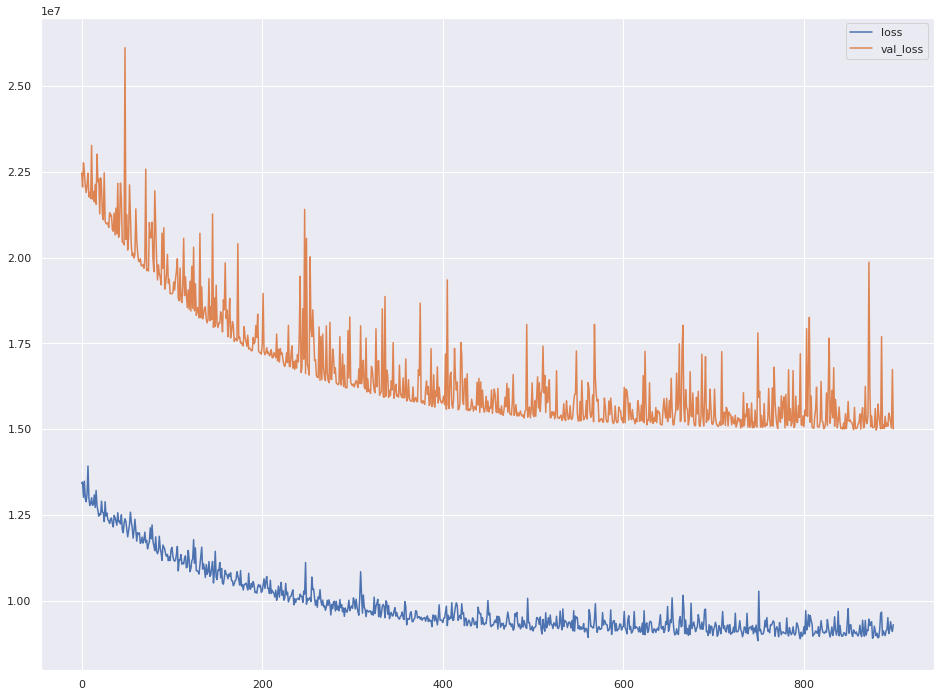

In [18]:
plot_history(history, offset=100)

In [19]:
def forecast(model, plot=True):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_index-window_size:]
    results = np.array(forecast)[:, 0, 0]

    if plot:
        plt.plot(time_train, train_data, 'g', label='Фактические данные')
        plt.plot(time_test, test_data, marker='.', label='Прогнозируемые реальные данные')
        plt.plot(time_test, results, 'r', label='Прогноз')
        plt.ylabel('Объем потребления газа')
        plt.xlabel('Время')
        plt.legend()
        plt.show(); 
        
        # Scale predictions
        plt.plot(time_test, test_data, marker='.', label="true")
        plt.plot(time_test, results, 'r', label="prediction")
        plt.ylabel('Value')
        plt.xlabel('Time Step')
        plt.legend()
        plt.show();        
    return results

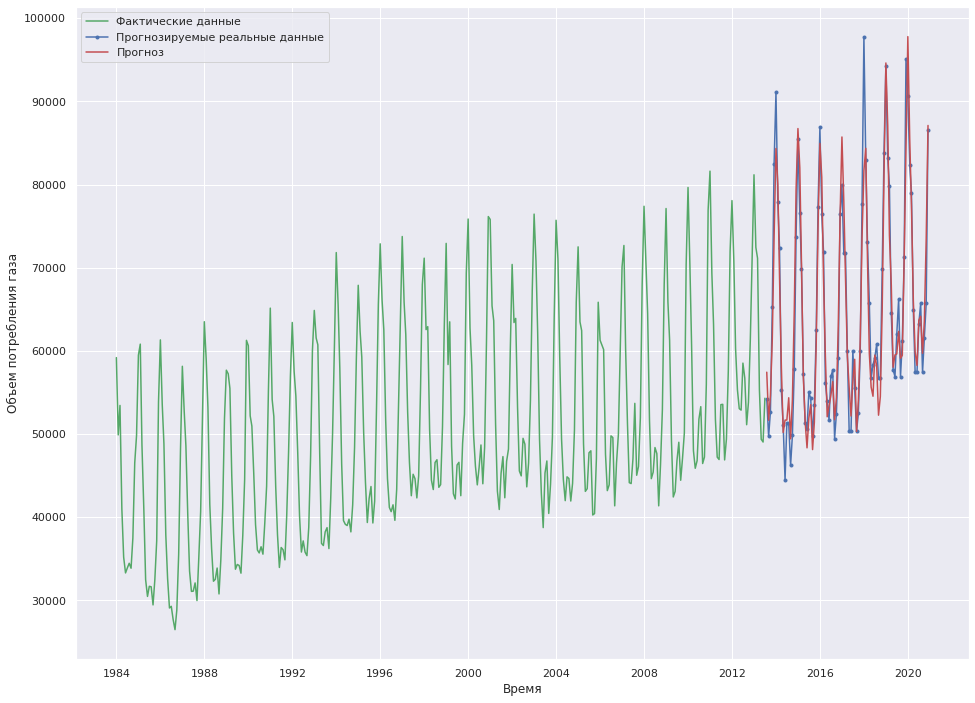

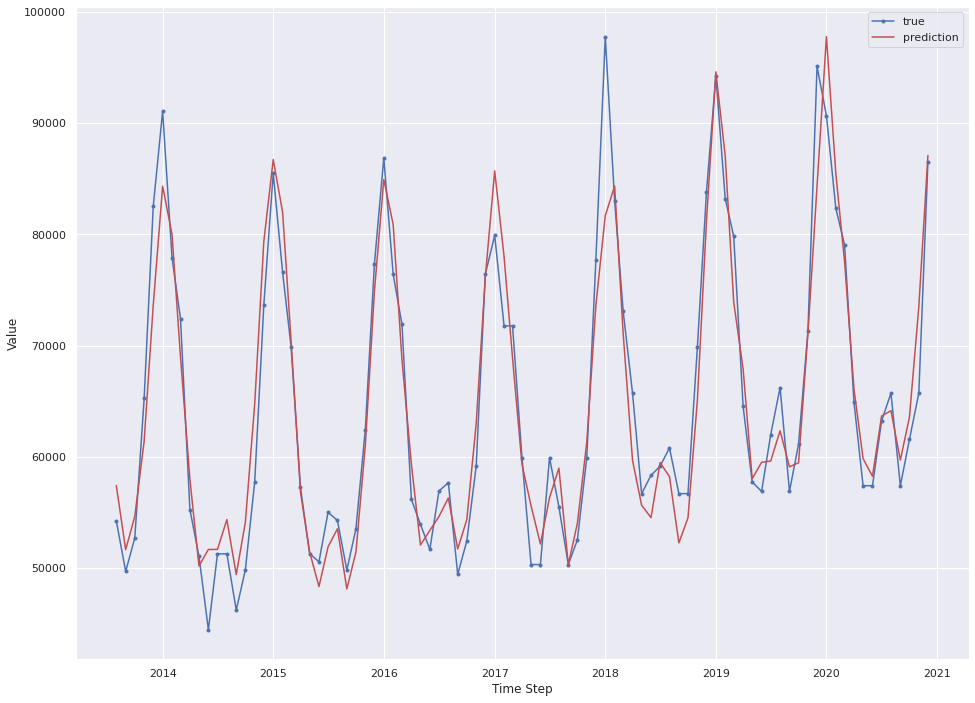

In [20]:
results = forecast(model)

In [21]:
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print('MAPE:', tf.keras.metrics.mean_absolute_percentage_error(x_valid, results).numpy())

MAE: 3021.302
MAPE: 4.5889544


In [22]:
model = tf.keras.models.Sequential([
    layers.Dense(32, input_shape=[window_size], activation='relu'), 
#     layers.Dropout(0.5),
    layers.Dense(32, activation='relu'), 
#     layers.Dropout(0.5),    
#     layers.Dense(32, activation='relu'), 
#     layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
history = model.fit(dataset, 
                    validation_data=validation_ds,
                    epochs=2500, verbose=1)

Epoch 1/2500
43/43 [==============================] - 1s 7ms/step - loss: 532306490.1818 - val_loss: 137768672.0000
Epoch 2/2500
43/43 [==============================] - 0s 3ms/step - loss: 88593855.8182 - val_loss: 75402072.0000
Epoch 3/2500
43/43 [==============================] - 0s 2ms/step - loss: 42516613.7273 - val_loss: 46346468.0000
Epoch 4/2500
43/43 [==============================] - 0s 2ms/step - loss: 29469756.8182 - val_loss: 33608400.0000
Epoch 5/2500
43/43 [==============================] - 0s 2ms/step - loss: 20586146.5909 - val_loss: 26080908.0000
Epoch 6/2500
43/43 [==============================] - 0s 2ms/step - loss: 13854635.4545 - val_loss: 24296230.0000
Epoch 7/2500
43/43 [==============================] - 0s 2ms/step - loss: 14785531.2841 - val_loss: 20955090.0000
Epoch 8/2500
43/43 [==============================] - 0s 2ms/step - loss: 10782441.8977 - val_loss: 19901854.0000
Epoch 9/2500
43/43 [==============================] - 0s 2ms/step - loss: 11946236.136

Epoch 73/2500
43/43 [==============================] - 0s 2ms/step - loss: 8238866.5227 - val_loss: 11548423.0000
Epoch 74/2500
43/43 [==============================] - 0s 2ms/step - loss: 7468556.2727 - val_loss: 12306207.0000
Epoch 75/2500
43/43 [==============================] - 0s 2ms/step - loss: 7268690.3636 - val_loss: 12677866.0000
Epoch 76/2500
43/43 [==============================] - 0s 2ms/step - loss: 7233106.2330 - val_loss: 17933048.0000
Epoch 77/2500
43/43 [==============================] - 0s 2ms/step - loss: 10879409.8182 - val_loss: 12660650.0000
Epoch 78/2500
43/43 [==============================] - 0s 2ms/step - loss: 7308602.0341 - val_loss: 11608994.0000
Epoch 79/2500
43/43 [==============================] - 0s 2ms/step - loss: 6100582.3466 - val_loss: 12392066.0000
Epoch 80/2500
43/43 [==============================] - 0s 2ms/step - loss: 7089643.1875 - val_loss: 15439480.0000
Epoch 81/2500
43/43 [==============================] - 0s 2ms/step - loss: 6546168.8068

43/43 [==============================] - 0s 2ms/step - loss: 5481833.7727 - val_loss: 11312505.0000
Epoch 145/2500
43/43 [==============================] - 0s 2ms/step - loss: 7229956.9545 - val_loss: 12174747.0000
Epoch 146/2500
43/43 [==============================] - 0s 2ms/step - loss: 6441834.1250 - val_loss: 16140976.0000
Epoch 147/2500
43/43 [==============================] - 0s 2ms/step - loss: 5634996.5682 - val_loss: 11813935.0000
Epoch 148/2500
43/43 [==============================] - 0s 2ms/step - loss: 6688625.7443 - val_loss: 12726393.0000
Epoch 149/2500
43/43 [==============================] - 0s 3ms/step - loss: 7675206.4659 - val_loss: 12274003.0000
Epoch 150/2500
43/43 [==============================] - 0s 2ms/step - loss: 6466329.3636 - val_loss: 12166563.0000
Epoch 151/2500
43/43 [==============================] - 0s 3ms/step - loss: 7567317.7102 - val_loss: 12294117.0000
Epoch 152/2500
43/43 [==============================] - 0s 3ms/step - loss: 7083282.0824 - val_

43/43 [==============================] - 0s 2ms/step - loss: 6749875.8864 - val_loss: 11399038.0000
Epoch 216/2500
43/43 [==============================] - 0s 2ms/step - loss: 5795306.0341 - val_loss: 12269748.0000
Epoch 217/2500
43/43 [==============================] - 0s 2ms/step - loss: 7312766.1932 - val_loss: 10559213.0000
Epoch 218/2500
43/43 [==============================] - 0s 2ms/step - loss: 6349370.9886 - val_loss: 11062476.0000
Epoch 219/2500
43/43 [==============================] - 0s 3ms/step - loss: 5890229.7670 - val_loss: 9736421.0000
Epoch 220/2500
43/43 [==============================] - 0s 3ms/step - loss: 7303604.2841 - val_loss: 11610342.0000
Epoch 221/2500
43/43 [==============================] - 0s 2ms/step - loss: 5989998.3466 - val_loss: 14134209.0000
Epoch 222/2500
43/43 [==============================] - 0s 2ms/step - loss: 7131973.5341 - val_loss: 10440378.0000
Epoch 223/2500
43/43 [==============================] - 0s 3ms/step - loss: 6844330.8295 - val_l

43/43 [==============================] - 0s 2ms/step - loss: 5319003.5625 - val_loss: 9863381.0000
Epoch 287/2500
43/43 [==============================] - 0s 2ms/step - loss: 5356237.0455 - val_loss: 10832621.0000
Epoch 288/2500
43/43 [==============================] - 0s 2ms/step - loss: 5929815.8409 - val_loss: 9396334.0000
Epoch 289/2500
43/43 [==============================] - 0s 2ms/step - loss: 6596537.1591 - val_loss: 13170125.0000
Epoch 290/2500
43/43 [==============================] - 0s 2ms/step - loss: 7236873.5682 - val_loss: 11398063.0000
Epoch 291/2500
43/43 [==============================] - 0s 2ms/step - loss: 6627768.1080 - val_loss: 10138394.0000
Epoch 292/2500
43/43 [==============================] - 0s 2ms/step - loss: 5334098.5000 - val_loss: 10740093.0000
Epoch 293/2500
43/43 [==============================] - 0s 2ms/step - loss: 5319693.7216 - val_loss: 10744922.0000
Epoch 294/2500
43/43 [==============================] - 0s 2ms/step - loss: 6332360.7045 - val_lo

43/43 [==============================] - 0s 2ms/step - loss: 6192497.9318 - val_loss: 12579546.0000
Epoch 358/2500
43/43 [==============================] - 0s 2ms/step - loss: 5913075.4773 - val_loss: 12878004.0000
Epoch 359/2500
43/43 [==============================] - 0s 2ms/step - loss: 5997748.9943 - val_loss: 10487855.0000
Epoch 360/2500
43/43 [==============================] - 0s 2ms/step - loss: 4972944.2216 - val_loss: 9960613.0000
Epoch 361/2500
43/43 [==============================] - 0s 2ms/step - loss: 6197913.1591 - val_loss: 10565980.0000
Epoch 362/2500
43/43 [==============================] - 0s 2ms/step - loss: 5914824.3977 - val_loss: 10639933.0000
Epoch 363/2500
43/43 [==============================] - 0s 2ms/step - loss: 5363662.8239 - val_loss: 13995956.0000
Epoch 364/2500
43/43 [==============================] - 0s 2ms/step - loss: 6026888.9489 - val_loss: 17255312.0000
Epoch 365/2500
43/43 [==============================] - 0s 2ms/step - loss: 8457770.5114 - val_l

43/43 [==============================] - 0s 2ms/step - loss: 7047592.8977 - val_loss: 11441271.0000
Epoch 429/2500
43/43 [==============================] - 0s 2ms/step - loss: 5936274.2784 - val_loss: 9358111.0000
Epoch 430/2500
43/43 [==============================] - 0s 2ms/step - loss: 6117194.3551 - val_loss: 10016337.0000
Epoch 431/2500
43/43 [==============================] - 0s 2ms/step - loss: 5705365.5000 - val_loss: 10390693.0000
Epoch 432/2500
43/43 [==============================] - 0s 2ms/step - loss: 5237608.5227 - val_loss: 16117413.0000
Epoch 433/2500
43/43 [==============================] - 0s 2ms/step - loss: 7229974.8750 - val_loss: 11122811.0000
Epoch 434/2500
43/43 [==============================] - 0s 2ms/step - loss: 6716913.0114 - val_loss: 10019938.0000
Epoch 435/2500
43/43 [==============================] - 0s 2ms/step - loss: 5442031.0000 - val_loss: 10313226.0000
Epoch 436/2500
43/43 [==============================] - 0s 2ms/step - loss: 6166143.4773 - val_l

43/43 [==============================] - 0s 3ms/step - loss: 6369330.1193 - val_loss: 10090153.0000
Epoch 500/2500
43/43 [==============================] - 0s 2ms/step - loss: 5697220.2955 - val_loss: 10195266.0000
Epoch 501/2500
43/43 [==============================] - 0s 2ms/step - loss: 5237664.6761 - val_loss: 11972522.0000
Epoch 502/2500
43/43 [==============================] - 0s 2ms/step - loss: 5534038.3295 - val_loss: 12530876.0000
Epoch 503/2500
43/43 [==============================] - 0s 2ms/step - loss: 5748422.5341 - val_loss: 11166255.0000
Epoch 504/2500
43/43 [==============================] - 0s 2ms/step - loss: 7356558.4545 - val_loss: 10398437.0000
Epoch 505/2500
43/43 [==============================] - 0s 2ms/step - loss: 5980402.4091 - val_loss: 9969639.0000
Epoch 506/2500
43/43 [==============================] - 0s 2ms/step - loss: 6435033.6477 - val_loss: 10920215.0000
Epoch 507/2500
43/43 [==============================] - 0s 3ms/step - loss: 6629258.9318 - val_l

43/43 [==============================] - 0s 3ms/step - loss: 5879305.3068 - val_loss: 8400306.0000
Epoch 571/2500
43/43 [==============================] - 0s 2ms/step - loss: 5244796.8239 - val_loss: 10907411.0000
Epoch 572/2500
43/43 [==============================] - 0s 3ms/step - loss: 5638288.3068 - val_loss: 9732254.0000
Epoch 573/2500
43/43 [==============================] - 0s 2ms/step - loss: 4967079.6477 - val_loss: 9993364.0000
Epoch 574/2500
43/43 [==============================] - 0s 3ms/step - loss: 5459253.2330 - val_loss: 9808461.0000
Epoch 575/2500
43/43 [==============================] - 0s 3ms/step - loss: 6747421.0682 - val_loss: 11142018.0000
Epoch 576/2500
43/43 [==============================] - 0s 3ms/step - loss: 6726551.4432 - val_loss: 10195948.0000
Epoch 577/2500
43/43 [==============================] - 0s 3ms/step - loss: 4369933.4148 - val_loss: 9479927.0000
Epoch 578/2500
43/43 [==============================] - 0s 3ms/step - loss: 4963924.4205 - val_loss:

43/43 [==============================] - 0s 2ms/step - loss: 5773834.1420 - val_loss: 9163838.0000
Epoch 642/2500
43/43 [==============================] - 0s 3ms/step - loss: 4746808.2557 - val_loss: 9196303.0000
Epoch 643/2500
43/43 [==============================] - 0s 3ms/step - loss: 5342258.3295 - val_loss: 10088504.0000
Epoch 644/2500
43/43 [==============================] - 0s 2ms/step - loss: 4904892.9034 - val_loss: 8801973.0000
Epoch 645/2500
43/43 [==============================] - 0s 2ms/step - loss: 4485418.6676 - val_loss: 12340674.0000
Epoch 646/2500
43/43 [==============================] - 0s 2ms/step - loss: 6282323.7159 - val_loss: 10905866.0000
Epoch 647/2500
43/43 [==============================] - 0s 2ms/step - loss: 5534695.5341 - val_loss: 9549713.0000
Epoch 648/2500
43/43 [==============================] - 0s 2ms/step - loss: 5336955.6250 - val_loss: 8968600.0000
Epoch 649/2500
43/43 [==============================] - 0s 2ms/step - loss: 5352304.1250 - val_loss:

43/43 [==============================] - 0s 2ms/step - loss: 5179317.9943 - val_loss: 8573679.0000
Epoch 713/2500
43/43 [==============================] - 0s 3ms/step - loss: 5068227.0341 - val_loss: 9276308.0000
Epoch 714/2500
43/43 [==============================] - 0s 3ms/step - loss: 5842251.2443 - val_loss: 10840265.0000
Epoch 715/2500
43/43 [==============================] - 0s 2ms/step - loss: 4867596.6676 - val_loss: 9227394.0000
Epoch 716/2500
43/43 [==============================] - 0s 3ms/step - loss: 5191483.2898 - val_loss: 10791890.0000
Epoch 717/2500
43/43 [==============================] - 0s 3ms/step - loss: 5740648.0682 - val_loss: 10688303.0000
Epoch 718/2500
43/43 [==============================] - 0s 3ms/step - loss: 4650656.4886 - val_loss: 9843059.0000
Epoch 719/2500
43/43 [==============================] - 0s 3ms/step - loss: 5483118.5284 - val_loss: 10094132.0000
Epoch 720/2500
43/43 [==============================] - 0s 3ms/step - loss: 4515008.3977 - val_loss

43/43 [==============================] - 0s 2ms/step - loss: 5014201.6023 - val_loss: 10167737.0000
Epoch 784/2500
43/43 [==============================] - 0s 2ms/step - loss: 5627324.2045 - val_loss: 11693026.0000
Epoch 785/2500
43/43 [==============================] - 0s 2ms/step - loss: 5205938.9205 - val_loss: 16994444.0000
Epoch 786/2500
43/43 [==============================] - 0s 2ms/step - loss: 5822301.0710 - val_loss: 9205959.0000
Epoch 787/2500
43/43 [==============================] - 0s 2ms/step - loss: 6502224.4773 - val_loss: 10620522.0000
Epoch 788/2500
43/43 [==============================] - 0s 2ms/step - loss: 4655169.6080 - val_loss: 10529898.0000
Epoch 789/2500
43/43 [==============================] - 0s 2ms/step - loss: 4589355.0625 - val_loss: 10561135.0000
Epoch 790/2500
43/43 [==============================] - 0s 2ms/step - loss: 6248874.2273 - val_loss: 8563825.0000
Epoch 791/2500
43/43 [==============================] - 0s 2ms/step - loss: 4257467.9773 - val_lo

43/43 [==============================] - 0s 2ms/step - loss: 4687820.7727 - val_loss: 10850509.0000
Epoch 855/2500
43/43 [==============================] - 0s 2ms/step - loss: 4959792.1875 - val_loss: 14463511.0000
Epoch 856/2500
43/43 [==============================] - 0s 2ms/step - loss: 6550899.6023 - val_loss: 13800716.0000
Epoch 857/2500
43/43 [==============================] - 0s 2ms/step - loss: 6016182.4659 - val_loss: 9838737.0000
Epoch 858/2500
43/43 [==============================] - 0s 2ms/step - loss: 4228243.2784 - val_loss: 10171206.0000
Epoch 859/2500
43/43 [==============================] - 0s 2ms/step - loss: 5270686.9545 - val_loss: 9766023.0000
Epoch 860/2500
43/43 [==============================] - 0s 2ms/step - loss: 5260358.2386 - val_loss: 9968875.0000
Epoch 861/2500
43/43 [==============================] - 0s 2ms/step - loss: 5344710.2330 - val_loss: 10335771.0000
Epoch 862/2500
43/43 [==============================] - 0s 2ms/step - loss: 6022133.6818 - val_los

43/43 [==============================] - 0s 2ms/step - loss: 3854513.4858 - val_loss: 9741251.0000
Epoch 926/2500
43/43 [==============================] - 0s 2ms/step - loss: 4474054.3750 - val_loss: 11174668.0000
Epoch 927/2500
43/43 [==============================] - 0s 3ms/step - loss: 5030451.2841 - val_loss: 11244785.0000
Epoch 928/2500
43/43 [==============================] - 0s 3ms/step - loss: 4582830.5398 - val_loss: 10190238.0000
Epoch 929/2500
43/43 [==============================] - 0s 3ms/step - loss: 4343764.2330 - val_loss: 10359961.0000
Epoch 930/2500
43/43 [==============================] - 0s 3ms/step - loss: 4732004.2102 - val_loss: 10072921.0000
Epoch 931/2500
43/43 [==============================] - 0s 3ms/step - loss: 5091659.4261 - val_loss: 11589629.0000
Epoch 932/2500
43/43 [==============================] - 0s 2ms/step - loss: 4866176.6193 - val_loss: 10080663.0000
Epoch 933/2500
43/43 [==============================] - 0s 2ms/step - loss: 3928340.4205 - val_l

43/43 [==============================] - 0s 2ms/step - loss: 4506220.4489 - val_loss: 9552571.0000
Epoch 997/2500
43/43 [==============================] - 0s 2ms/step - loss: 4929515.3239 - val_loss: 10413093.0000
Epoch 998/2500
43/43 [==============================] - 0s 2ms/step - loss: 4815007.0114 - val_loss: 10835164.0000
Epoch 999/2500
43/43 [==============================] - 0s 2ms/step - loss: 4291784.9432 - val_loss: 10112037.0000
Epoch 1000/2500
43/43 [==============================] - 0s 2ms/step - loss: 5617391.4659 - val_loss: 11323737.0000
Epoch 1001/2500
43/43 [==============================] - 0s 2ms/step - loss: 4213241.7386 - val_loss: 10874461.0000
Epoch 1002/2500
43/43 [==============================] - 0s 2ms/step - loss: 5428932.4659 - val_loss: 10022703.0000
Epoch 1003/2500
43/43 [==============================] - 0s 2ms/step - loss: 4626536.8977 - val_loss: 11106467.0000
Epoch 1004/2500
43/43 [==============================] - 0s 3ms/step - loss: 4783589.9261 - 

43/43 [==============================] - 0s 2ms/step - loss: 5297295.2955 - val_loss: 9092847.0000
Epoch 1068/2500
43/43 [==============================] - 0s 2ms/step - loss: 5160902.6989 - val_loss: 10436357.0000
Epoch 1069/2500
43/43 [==============================] - 0s 2ms/step - loss: 5928938.6818 - val_loss: 10511611.0000
Epoch 1070/2500
43/43 [==============================] - 0s 2ms/step - loss: 4794605.2955 - val_loss: 11017722.0000
Epoch 1071/2500
43/43 [==============================] - 0s 2ms/step - loss: 4808044.0227 - val_loss: 10035374.0000
Epoch 1072/2500
43/43 [==============================] - 0s 2ms/step - loss: 3508179.6932 - val_loss: 9984401.0000
Epoch 1073/2500
43/43 [==============================] - 0s 2ms/step - loss: 4147586.5227 - val_loss: 10334308.0000
Epoch 1074/2500
43/43 [==============================] - 0s 2ms/step - loss: 4471062.4787 - val_loss: 11460906.0000
Epoch 1075/2500
43/43 [==============================] - 0s 2ms/step - loss: 4526727.4659 

Epoch 1138/2500
43/43 [==============================] - 0s 2ms/step - loss: 4278458.5114 - val_loss: 10738061.0000
Epoch 1139/2500
43/43 [==============================] - 0s 2ms/step - loss: 4467021.3750 - val_loss: 11017264.0000
Epoch 1140/2500
43/43 [==============================] - 0s 2ms/step - loss: 5625135.8267 - val_loss: 10014331.0000
Epoch 1141/2500
43/43 [==============================] - 0s 2ms/step - loss: 4486276.2784 - val_loss: 9001228.0000
Epoch 1142/2500
43/43 [==============================] - 0s 2ms/step - loss: 4525276.7841 - val_loss: 10630883.0000
Epoch 1143/2500
43/43 [==============================] - 0s 2ms/step - loss: 3814872.6023 - val_loss: 12111092.0000
Epoch 1144/2500
43/43 [==============================] - 0s 2ms/step - loss: 4548098.0455 - val_loss: 10189241.0000
Epoch 1145/2500
43/43 [==============================] - 0s 2ms/step - loss: 4448964.9659 - val_loss: 9724765.0000
Epoch 1146/2500
43/43 [==============================] - 0s 2ms/step - los

Epoch 1209/2500
43/43 [==============================] - 0s 3ms/step - loss: 3774518.1108 - val_loss: 11536174.0000
Epoch 1210/2500
43/43 [==============================] - 0s 3ms/step - loss: 4782278.8352 - val_loss: 11199221.0000
Epoch 1211/2500
43/43 [==============================] - 0s 3ms/step - loss: 4141508.3807 - val_loss: 9911465.0000
Epoch 1212/2500
43/43 [==============================] - 0s 3ms/step - loss: 4282792.9205 - val_loss: 12456710.0000
Epoch 1213/2500
43/43 [==============================] - 0s 3ms/step - loss: 5689537.6705 - val_loss: 9731598.0000
Epoch 1214/2500
43/43 [==============================] - 0s 3ms/step - loss: 5129131.8494 - val_loss: 11398545.0000
Epoch 1215/2500
43/43 [==============================] - 0s 2ms/step - loss: 3858984.4432 - val_loss: 13998609.0000
Epoch 1216/2500
43/43 [==============================] - 0s 2ms/step - loss: 5019200.4602 - val_loss: 12748153.0000
Epoch 1217/2500
43/43 [==============================] - 0s 2ms/step - los

Epoch 1280/2500
43/43 [==============================] - 0s 2ms/step - loss: 4007774.4091 - val_loss: 9773426.0000
Epoch 1281/2500
43/43 [==============================] - 0s 2ms/step - loss: 3625588.5625 - val_loss: 11603528.0000
Epoch 1282/2500
43/43 [==============================] - 0s 2ms/step - loss: 4748593.4148 - val_loss: 9620362.0000
Epoch 1283/2500
43/43 [==============================] - 0s 2ms/step - loss: 4658722.3409 - val_loss: 9688433.0000
Epoch 1284/2500
43/43 [==============================] - 0s 3ms/step - loss: 3829916.7841 - val_loss: 9413763.0000
Epoch 1285/2500
43/43 [==============================] - 0s 2ms/step - loss: 4704409.9602 - val_loss: 13597588.0000
Epoch 1286/2500
43/43 [==============================] - 0s 2ms/step - loss: 5182466.3864 - val_loss: 12213625.0000
Epoch 1287/2500
43/43 [==============================] - 0s 2ms/step - loss: 5025512.8864 - val_loss: 10552618.0000
Epoch 1288/2500
43/43 [==============================] - 0s 2ms/step - loss:

Epoch 1351/2500
43/43 [==============================] - 0s 2ms/step - loss: 4198853.8239 - val_loss: 11620904.0000
Epoch 1352/2500
43/43 [==============================] - 0s 2ms/step - loss: 4658922.0227 - val_loss: 10959748.0000
Epoch 1353/2500
43/43 [==============================] - 0s 2ms/step - loss: 4876834.2045 - val_loss: 9754280.0000
Epoch 1354/2500
43/43 [==============================] - 0s 2ms/step - loss: 4331458.5170 - val_loss: 10296106.0000
Epoch 1355/2500
43/43 [==============================] - 0s 2ms/step - loss: 4825271.0966 - val_loss: 10679962.0000
Epoch 1356/2500
43/43 [==============================] - 0s 2ms/step - loss: 4131119.1534 - val_loss: 12266767.0000
Epoch 1357/2500
43/43 [==============================] - 0s 2ms/step - loss: 4411891.7386 - val_loss: 10073241.0000
Epoch 1358/2500
43/43 [==============================] - 0s 3ms/step - loss: 4017091.3636 - val_loss: 11135291.0000
Epoch 1359/2500
43/43 [==============================] - 0s 2ms/step - lo

Epoch 1422/2500
43/43 [==============================] - 0s 3ms/step - loss: 4067299.2557 - val_loss: 9786035.0000
Epoch 1423/2500
43/43 [==============================] - 0s 3ms/step - loss: 3800860.7102 - val_loss: 9429408.0000
Epoch 1424/2500
43/43 [==============================] - 0s 3ms/step - loss: 3809964.1307 - val_loss: 12326525.0000
Epoch 1425/2500
43/43 [==============================] - 0s 3ms/step - loss: 5139301.9773 - val_loss: 10742092.0000
Epoch 1426/2500
43/43 [==============================] - 0s 3ms/step - loss: 5014686.9886 - val_loss: 10794629.0000
Epoch 1427/2500
43/43 [==============================] - 0s 3ms/step - loss: 3614281.8636 - val_loss: 9866885.0000
Epoch 1428/2500
43/43 [==============================] - 0s 3ms/step - loss: 4091928.4091 - val_loss: 9514548.0000
Epoch 1429/2500
43/43 [==============================] - 0s 3ms/step - loss: 3960790.3864 - val_loss: 9273883.0000
Epoch 1430/2500
43/43 [==============================] - 0s 5ms/step - loss: 

Epoch 1493/2500
43/43 [==============================] - 0s 2ms/step - loss: 3642329.0227 - val_loss: 12889123.0000
Epoch 1494/2500
43/43 [==============================] - 0s 2ms/step - loss: 4476751.5170 - val_loss: 11279990.0000
Epoch 1495/2500
43/43 [==============================] - 0s 2ms/step - loss: 4450031.3523 - val_loss: 9951538.0000
Epoch 1496/2500
43/43 [==============================] - 0s 2ms/step - loss: 4211539.3295 - val_loss: 11433591.0000
Epoch 1497/2500
43/43 [==============================] - 0s 2ms/step - loss: 3786202.7557 - val_loss: 10744744.0000
Epoch 1498/2500
43/43 [==============================] - 0s 2ms/step - loss: 4453168.4375 - val_loss: 10540636.0000
Epoch 1499/2500
43/43 [==============================] - 0s 2ms/step - loss: 4124098.1989 - val_loss: 9595308.0000
Epoch 1500/2500
43/43 [==============================] - 0s 2ms/step - loss: 4437999.0000 - val_loss: 9362035.0000
Epoch 1501/2500
43/43 [==============================] - 0s 2ms/step - loss

Epoch 1564/2500
43/43 [==============================] - 0s 2ms/step - loss: 3755793.5369 - val_loss: 9338736.0000
Epoch 1565/2500
43/43 [==============================] - 0s 2ms/step - loss: 4963543.6989 - val_loss: 9626469.0000
Epoch 1566/2500
43/43 [==============================] - 0s 2ms/step - loss: 4983897.8636 - val_loss: 10887853.0000
Epoch 1567/2500
43/43 [==============================] - 0s 2ms/step - loss: 4392593.4432 - val_loss: 9642362.0000
Epoch 1568/2500
43/43 [==============================] - 0s 2ms/step - loss: 4106462.4602 - val_loss: 10933672.0000
Epoch 1569/2500
43/43 [==============================] - 0s 2ms/step - loss: 5003533.6023 - val_loss: 9487799.0000
Epoch 1570/2500
43/43 [==============================] - 0s 2ms/step - loss: 5715193.4205 - val_loss: 9434185.0000
Epoch 1571/2500
43/43 [==============================] - 0s 2ms/step - loss: 4337512.2131 - val_loss: 10254137.0000
Epoch 1572/2500
43/43 [==============================] - 0s 2ms/step - loss: 

Epoch 1635/2500
43/43 [==============================] - 0s 2ms/step - loss: 4233843.0511 - val_loss: 13012897.0000
Epoch 1636/2500
43/43 [==============================] - 0s 2ms/step - loss: 4620700.0625 - val_loss: 11049784.0000
Epoch 1637/2500
43/43 [==============================] - 0s 2ms/step - loss: 3772998.8182 - val_loss: 9174657.0000
Epoch 1638/2500
43/43 [==============================] - 0s 2ms/step - loss: 4200948.2386 - val_loss: 10124906.0000
Epoch 1639/2500
43/43 [==============================] - 0s 2ms/step - loss: 4024873.6548 - val_loss: 10389978.0000
Epoch 1640/2500
43/43 [==============================] - 0s 2ms/step - loss: 4421025.0682 - val_loss: 11303448.0000
Epoch 1641/2500
43/43 [==============================] - 0s 2ms/step - loss: 4061430.1250 - val_loss: 9207634.0000
Epoch 1642/2500
43/43 [==============================] - 0s 2ms/step - loss: 3954419.5852 - val_loss: 10380049.0000
Epoch 1643/2500
43/43 [==============================] - 0s 2ms/step - los

Epoch 1706/2500
43/43 [==============================] - 0s 2ms/step - loss: 4338854.2670 - val_loss: 9787241.0000
Epoch 1707/2500
43/43 [==============================] - 0s 2ms/step - loss: 3767316.0625 - val_loss: 13605630.0000
Epoch 1708/2500
43/43 [==============================] - 0s 2ms/step - loss: 5028537.7500 - val_loss: 9154369.0000
Epoch 1709/2500
43/43 [==============================] - 0s 2ms/step - loss: 5444525.9432 - val_loss: 9321502.0000
Epoch 1710/2500
43/43 [==============================] - 0s 2ms/step - loss: 3937426.4489 - val_loss: 9602319.0000
Epoch 1711/2500
43/43 [==============================] - 0s 2ms/step - loss: 4063460.2045 - val_loss: 11368574.0000
Epoch 1712/2500
43/43 [==============================] - 0s 2ms/step - loss: 4141663.8011 - val_loss: 13303499.0000
Epoch 1713/2500
43/43 [==============================] - 0s 2ms/step - loss: 4738800.9659 - val_loss: 9898189.0000
Epoch 1714/2500
43/43 [==============================] - 0s 2ms/step - loss: 

Epoch 1777/2500
43/43 [==============================] - 0s 2ms/step - loss: 4515721.2017 - val_loss: 11638117.0000
Epoch 1778/2500
43/43 [==============================] - 0s 2ms/step - loss: 4608261.4205 - val_loss: 10887068.0000
Epoch 1779/2500
43/43 [==============================] - 0s 2ms/step - loss: 3762932.7614 - val_loss: 9998393.0000
Epoch 1780/2500
43/43 [==============================] - 0s 3ms/step - loss: 3941528.0469 - val_loss: 9597943.0000
Epoch 1781/2500
43/43 [==============================] - 0s 2ms/step - loss: 3888763.6960 - val_loss: 10886764.0000
Epoch 1782/2500
43/43 [==============================] - 0s 2ms/step - loss: 4640513.6250 - val_loss: 10441517.0000
Epoch 1783/2500
43/43 [==============================] - 0s 2ms/step - loss: 5320618.6477 - val_loss: 10523841.0000
Epoch 1784/2500
43/43 [==============================] - 0s 2ms/step - loss: 4070014.3295 - val_loss: 9476026.0000
Epoch 1785/2500
43/43 [==============================] - 0s 2ms/step - loss

Epoch 1848/2500
43/43 [==============================] - 0s 2ms/step - loss: 4545665.7159 - val_loss: 9186060.0000
Epoch 1849/2500
43/43 [==============================] - 0s 2ms/step - loss: 4133260.5170 - val_loss: 10327268.0000
Epoch 1850/2500
43/43 [==============================] - 0s 2ms/step - loss: 3632292.7784 - val_loss: 10075995.0000
Epoch 1851/2500
43/43 [==============================] - 0s 2ms/step - loss: 4067274.3011 - val_loss: 9143663.0000
Epoch 1852/2500
43/43 [==============================] - 0s 2ms/step - loss: 4336455.8636 - val_loss: 9163952.0000
Epoch 1853/2500
43/43 [==============================] - 0s 2ms/step - loss: 4376730.4489 - val_loss: 10439381.0000
Epoch 1854/2500
43/43 [==============================] - 0s 2ms/step - loss: 3859710.3239 - val_loss: 9286986.0000
Epoch 1855/2500
43/43 [==============================] - 0s 2ms/step - loss: 4152490.7131 - val_loss: 10897453.0000
Epoch 1856/2500
43/43 [==============================] - 0s 2ms/step - loss:

43/43 [==============================] - 0s 2ms/step - loss: 3497845.5483 - val_loss: 9247201.0000
Epoch 1920/2500
43/43 [==============================] - 0s 2ms/step - loss: 4187296.6207 - val_loss: 8929174.0000
Epoch 1921/2500
43/43 [==============================] - 0s 2ms/step - loss: 3930016.4034 - val_loss: 9481374.0000
Epoch 1922/2500
43/43 [==============================] - 0s 2ms/step - loss: 3508988.2784 - val_loss: 9774590.0000
Epoch 1923/2500
43/43 [==============================] - 0s 2ms/step - loss: 4100676.9545 - val_loss: 10057366.0000
Epoch 1924/2500
43/43 [==============================] - 0s 2ms/step - loss: 4391133.3381 - val_loss: 9411288.0000
Epoch 1925/2500
43/43 [==============================] - 0s 2ms/step - loss: 4261353.5909 - val_loss: 9556448.0000
Epoch 1926/2500
43/43 [==============================] - 0s 2ms/step - loss: 4319103.3466 - val_loss: 14910417.0000
Epoch 1927/2500
43/43 [==============================] - 0s 2ms/step - loss: 4991496.2443 - va

43/43 [==============================] - 0s 2ms/step - loss: 3916957.1591 - val_loss: 10387034.0000
Epoch 1991/2500
43/43 [==============================] - 0s 2ms/step - loss: 3615231.3693 - val_loss: 14141194.0000
Epoch 1992/2500
43/43 [==============================] - 0s 2ms/step - loss: 4522110.0795 - val_loss: 9138725.0000
Epoch 1993/2500
43/43 [==============================] - 0s 2ms/step - loss: 3928916.2045 - val_loss: 12188074.0000
Epoch 1994/2500
43/43 [==============================] - 0s 2ms/step - loss: 4202177.5398 - val_loss: 9023318.0000
Epoch 1995/2500
43/43 [==============================] - 0s 2ms/step - loss: 4188692.1449 - val_loss: 10533510.0000
Epoch 1996/2500
43/43 [==============================] - 0s 2ms/step - loss: 4401084.1307 - val_loss: 8523453.0000
Epoch 1997/2500
43/43 [==============================] - 0s 2ms/step - loss: 3362048.1761 - val_loss: 10669676.0000
Epoch 1998/2500
43/43 [==============================] - 0s 3ms/step - loss: 3742418.3693 -

43/43 [==============================] - 0s 2ms/step - loss: 4425005.2670 - val_loss: 10153511.0000
Epoch 2062/2500
43/43 [==============================] - 0s 2ms/step - loss: 4755981.8807 - val_loss: 11401941.0000
Epoch 2063/2500
43/43 [==============================] - 0s 4ms/step - loss: 3825934.7045 - val_loss: 9863970.0000
Epoch 2064/2500
43/43 [==============================] - 0s 4ms/step - loss: 3477178.6250 - val_loss: 10390168.0000
Epoch 2065/2500
43/43 [==============================] - 0s 2ms/step - loss: 4212388.4375 - val_loss: 9606283.0000
Epoch 2066/2500
43/43 [==============================] - 0s 2ms/step - loss: 3662732.3920 - val_loss: 9784494.0000
Epoch 2067/2500
43/43 [==============================] - 0s 2ms/step - loss: 3651183.9915 - val_loss: 9185928.0000
Epoch 2068/2500
43/43 [==============================] - 0s 2ms/step - loss: 4284970.1932 - val_loss: 10380094.0000
Epoch 2069/2500
43/43 [==============================] - 0s 2ms/step - loss: 3720858.6591 - 

43/43 [==============================] - 0s 2ms/step - loss: 3619896.8011 - val_loss: 11533594.0000
Epoch 2133/2500
43/43 [==============================] - 0s 2ms/step - loss: 3654181.9375 - val_loss: 11064188.0000
Epoch 2134/2500
43/43 [==============================] - 0s 2ms/step - loss: 3587459.1307 - val_loss: 9874869.0000
Epoch 2135/2500
43/43 [==============================] - 0s 2ms/step - loss: 3947848.1307 - val_loss: 10442787.0000
Epoch 2136/2500
43/43 [==============================] - 0s 2ms/step - loss: 3954625.3580 - val_loss: 10985378.0000
Epoch 2137/2500
43/43 [==============================] - 0s 2ms/step - loss: 5157796.9830 - val_loss: 8263510.5000
Epoch 2138/2500
43/43 [==============================] - 0s 2ms/step - loss: 4668836.0682 - val_loss: 9498753.0000
Epoch 2139/2500
43/43 [==============================] - 0s 2ms/step - loss: 3766968.3068 - val_loss: 10098420.0000
Epoch 2140/2500
43/43 [==============================] - 0s 2ms/step - loss: 3320074.5085 -

43/43 [==============================] - 0s 2ms/step - loss: 4970988.5625 - val_loss: 9370499.0000
Epoch 2204/2500
43/43 [==============================] - 0s 2ms/step - loss: 3367923.7216 - val_loss: 10398188.0000
Epoch 2205/2500
43/43 [==============================] - 0s 5ms/step - loss: 4058015.6477 - val_loss: 9905049.0000
Epoch 2206/2500
43/43 [==============================] - 0s 3ms/step - loss: 3414449.4957 - val_loss: 9542469.0000
Epoch 2207/2500
43/43 [==============================] - 0s 2ms/step - loss: 3712201.6477 - val_loss: 9190029.0000
Epoch 2208/2500
43/43 [==============================] - 0s 2ms/step - loss: 3613559.5682 - val_loss: 10289917.0000
Epoch 2209/2500
43/43 [==============================] - 0s 2ms/step - loss: 3825979.0795 - val_loss: 11816903.0000
Epoch 2210/2500
43/43 [==============================] - 0s 2ms/step - loss: 4510966.6477 - val_loss: 9727377.0000
Epoch 2211/2500
43/43 [==============================] - 0s 2ms/step - loss: 4608455.0341 - v

43/43 [==============================] - 0s 2ms/step - loss: 3290315.2727 - val_loss: 8785936.0000
Epoch 2275/2500
43/43 [==============================] - 0s 2ms/step - loss: 4089307.6534 - val_loss: 9222802.0000
Epoch 2276/2500
43/43 [==============================] - 0s 2ms/step - loss: 3782816.4034 - val_loss: 9299941.0000
Epoch 2277/2500
43/43 [==============================] - 0s 2ms/step - loss: 3936285.8977 - val_loss: 9459058.0000
Epoch 2278/2500
43/43 [==============================] - 0s 2ms/step - loss: 4031623.7784 - val_loss: 11931951.0000
Epoch 2279/2500
43/43 [==============================] - 0s 2ms/step - loss: 4650745.1364 - val_loss: 9128692.0000
Epoch 2280/2500
43/43 [==============================] - 0s 2ms/step - loss: 3824120.9688 - val_loss: 9843474.0000
Epoch 2281/2500
43/43 [==============================] - 0s 2ms/step - loss: 3616941.8352 - val_loss: 10002010.0000
Epoch 2282/2500
43/43 [==============================] - 0s 2ms/step - loss: 4039789.8182 - va

43/43 [==============================] - 0s 2ms/step - loss: 3488757.5653 - val_loss: 9770263.0000
Epoch 2346/2500
43/43 [==============================] - 0s 3ms/step - loss: 3425207.4659 - val_loss: 10271510.0000
Epoch 2347/2500
43/43 [==============================] - 0s 3ms/step - loss: 3480715.8352 - val_loss: 9846989.0000
Epoch 2348/2500
43/43 [==============================] - 0s 3ms/step - loss: 3419757.6477 - val_loss: 9875059.0000
Epoch 2349/2500
43/43 [==============================] - 0s 2ms/step - loss: 4233484.6193 - val_loss: 10351805.0000
Epoch 2350/2500
43/43 [==============================] - 0s 2ms/step - loss: 3565230.0227 - val_loss: 11413750.0000
Epoch 2351/2500
43/43 [==============================] - 0s 2ms/step - loss: 4928550.8182 - val_loss: 12095105.0000
Epoch 2352/2500
43/43 [==============================] - 0s 2ms/step - loss: 3497678.7045 - val_loss: 11188668.0000
Epoch 2353/2500
43/43 [==============================] - 0s 2ms/step - loss: 3927140.7216 -

43/43 [==============================] - 0s 3ms/step - loss: 3580152.3693 - val_loss: 10393785.0000
Epoch 2417/2500
43/43 [==============================] - 0s 3ms/step - loss: 4246950.3580 - val_loss: 11255284.0000
Epoch 2418/2500
43/43 [==============================] - 0s 2ms/step - loss: 4931805.4205 - val_loss: 10178274.0000
Epoch 2419/2500
43/43 [==============================] - 0s 3ms/step - loss: 4069311.1080 - val_loss: 10169482.0000
Epoch 2420/2500
43/43 [==============================] - 0s 3ms/step - loss: 3930981.0114 - val_loss: 11034129.0000
Epoch 2421/2500
43/43 [==============================] - 0s 3ms/step - loss: 4493444.1761 - val_loss: 10085227.0000
Epoch 2422/2500
43/43 [==============================] - 0s 2ms/step - loss: 3653704.0881 - val_loss: 10031783.0000
Epoch 2423/2500
43/43 [==============================] - 0s 2ms/step - loss: 3594881.6875 - val_loss: 11720327.0000
Epoch 2424/2500
43/43 [==============================] - 0s 3ms/step - loss: 4088260.585

Epoch 2487/2500
43/43 [==============================] - 0s 3ms/step - loss: 3854118.5000 - val_loss: 9003884.0000
Epoch 2488/2500
43/43 [==============================] - 0s 3ms/step - loss: 3539377.7330 - val_loss: 9400333.0000
Epoch 2489/2500
43/43 [==============================] - 0s 2ms/step - loss: 4060527.5455 - val_loss: 10079692.0000
Epoch 2490/2500
43/43 [==============================] - 0s 2ms/step - loss: 3878381.0142 - val_loss: 12616424.0000
Epoch 2491/2500
43/43 [==============================] - 0s 2ms/step - loss: 5414736.4545 - val_loss: 10540308.0000
Epoch 2492/2500
43/43 [==============================] - 0s 3ms/step - loss: 3204292.0426 - val_loss: 10036472.0000
Epoch 2493/2500
43/43 [==============================] - 0s 2ms/step - loss: 3186843.4375 - val_loss: 13799862.0000
Epoch 2494/2500
43/43 [==============================] - 0s 2ms/step - loss: 5133624.4545 - val_loss: 9820698.0000
Epoch 2495/2500
43/43 [==============================] - 0s 2ms/step - loss

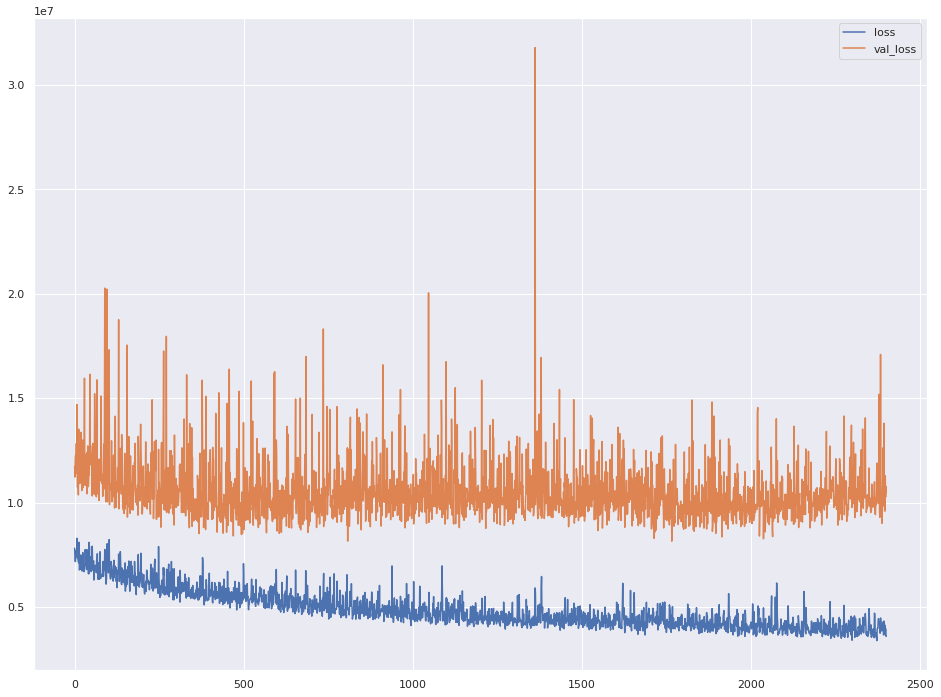

In [23]:
plot_history(history, offset=100)

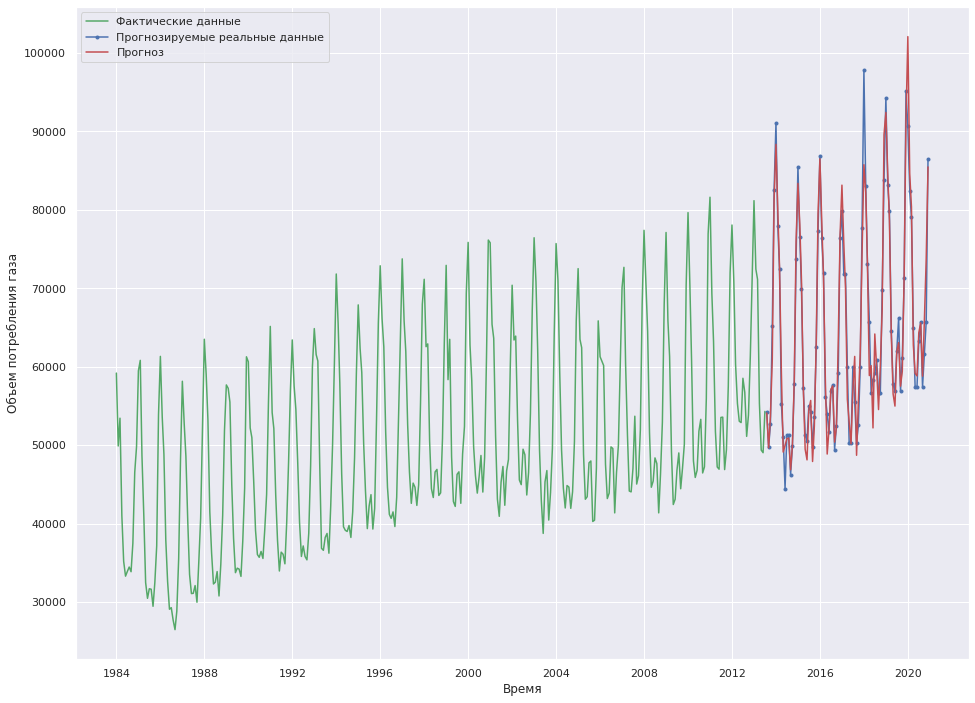

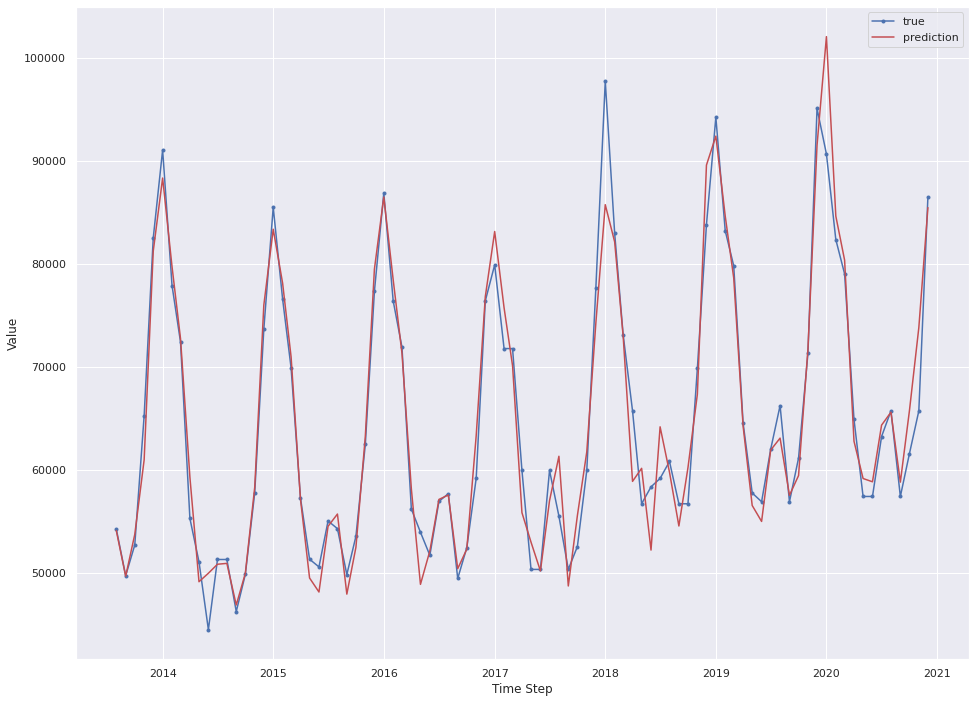

In [24]:
results = forecast(model)

In [25]:
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print('MAPE:', tf.keras.metrics.mean_absolute_percentage_error(x_valid, results).numpy())

MAE: 2230.321
MAPE: 3.4253352


### LSTM

In [26]:
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
def generate_rnn_series(series, n_input, batch_size):
    return TimeseriesGenerator(series, series, length=n_input, batch_size=batch_size)

In [27]:
n_features = 1
series_data = series.reshape((len(series), n_features))
generator = generate_rnn_series(series_data, 12, batch_size=1)

In [28]:
generator[0]

(array([[[59191.2 ],
         [49898.24],
         [53440.16],
         [41004.24],
         [35196.24],
         [33298.24],
         [33893.2 ],
         [34460.24],
         [33863.2 ],
         [37491.2 ],
         [46528.16],
         [49814.24]]]),
 array([[59480.]]))

In [29]:
model = tf.keras.models.Sequential([
     layers.LSTM(64, return_sequences=False),
#      layers.LSTM(32, return_sequences=False),
     layers.Dense(12),
     layers.Dense(1),
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
history = model.fit(generator, steps_per_epoch=100, epochs=1000,
#                      validation_data=validation_ds,
#                     epochs=2500, 
                    verbose=1)

# model.summary()

Epoch 1/1000
100/100 [==============================] - 2s 4ms/step - loss: 2847136882.6931
Epoch 2/1000
100/100 [==============================] - 0s 3ms/step - loss: 2891963594.7723
Epoch 3/1000
100/100 [==============================] - 0s 2ms/step - loss: 2883439024.1584
Epoch 4/1000
100/100 [==============================] - 0s 3ms/step - loss: 2767774752.9505
Epoch 5/1000
100/100 [==============================] - 0s 3ms/step - loss: 3028459066.2970
Epoch 6/1000
100/100 [==============================] - 0s 3ms/step - loss: 3236668929.2673
Epoch 7/1000
100/100 [==============================] - 0s 2ms/step - loss: 3259942222.5743
Epoch 8/1000
100/100 [==============================] - 0s 2ms/step - loss: 3211862265.6634
Epoch 9/1000
100/100 [==============================] - 0s 4ms/step - loss: 3212760370.6931
Epoch 10/1000
100/100 [==============================] - 0s 2ms/step - loss: 2790279742.0990
Epoch 11/1000
100/100 [==============================] - 0s 3ms/step - loss: 31

100/100 [==============================] - 0s 3ms/step - loss: 1368969148.1980
Epoch 90/1000
100/100 [==============================] - 0s 3ms/step - loss: 1281235511.7624
Epoch 91/1000
100/100 [==============================] - 0s 2ms/step - loss: 1248060756.9109
Epoch 92/1000
100/100 [==============================] - 0s 2ms/step - loss: 1156055857.4257
Epoch 93/1000
100/100 [==============================] - 0s 2ms/step - loss: 1302562046.4158
Epoch 94/1000
100/100 [==============================] - 0s 2ms/step - loss: 1404761428.5941
Epoch 95/1000
100/100 [==============================] - 0s 2ms/step - loss: 1279455332.4356
Epoch 96/1000
100/100 [==============================] - 0s 2ms/step - loss: 1109693371.5644
Epoch 97/1000
100/100 [==============================] - 0s 2ms/step - loss: 1242424431.5248
Epoch 98/1000
100/100 [==============================] - 0s 2ms/step - loss: 1091023842.6139
Epoch 99/1000
100/100 [==============================] - 0s 2ms/step - loss: 9860022

100/100 [==============================] - 0s 2ms/step - loss: 199446876.5149
Epoch 178/1000
100/100 [==============================] - 0s 2ms/step - loss: 188786806.0990
Epoch 179/1000
100/100 [==============================] - 0s 2ms/step - loss: 165080901.7030
Epoch 180/1000
100/100 [==============================] - 0s 2ms/step - loss: 273140172.2475
Epoch 181/1000
100/100 [==============================] - 0s 2ms/step - loss: 162497439.5248
Epoch 182/1000
100/100 [==============================] - 0s 2ms/step - loss: 161647295.0495
Epoch 183/1000
100/100 [==============================] - 0s 2ms/step - loss: 174117826.6931
Epoch 184/1000
100/100 [==============================] - 0s 2ms/step - loss: 248644420.1188
Epoch 185/1000
100/100 [==============================] - 0s 2ms/step - loss: 248874505.6634
Epoch 186/1000
100/100 [==============================] - 0s 4ms/step - loss: 131560639.5248
Epoch 187/1000
100/100 [==============================] - 0s 3ms/step - loss: 2182325

100/100 [==============================] - 0s 2ms/step - loss: 235297084.6733
Epoch 266/1000
100/100 [==============================] - 0s 2ms/step - loss: 161068695.2574
Epoch 267/1000
100/100 [==============================] - 0s 2ms/step - loss: 152441025.1881
Epoch 268/1000
100/100 [==============================] - 0s 2ms/step - loss: 219269286.8218
Epoch 269/1000
100/100 [==============================] - 0s 2ms/step - loss: 189705101.7624
Epoch 270/1000
100/100 [==============================] - 0s 2ms/step - loss: 160293793.3465
Epoch 271/1000
100/100 [==============================] - 0s 2ms/step - loss: 191932420.2871
Epoch 272/1000
100/100 [==============================] - 0s 2ms/step - loss: 156649160.3168
Epoch 273/1000
100/100 [==============================] - 0s 2ms/step - loss: 186831621.5446
Epoch 274/1000
100/100 [==============================] - 0s 2ms/step - loss: 214492277.8614
Epoch 275/1000
100/100 [==============================] - 0s 2ms/step - loss: 1677467

100/100 [==============================] - 0s 2ms/step - loss: 245875217.1089
Epoch 354/1000
100/100 [==============================] - 0s 3ms/step - loss: 125944256.7921
Epoch 355/1000
100/100 [==============================] - 0s 3ms/step - loss: 229576932.4356
Epoch 356/1000
100/100 [==============================] - 0s 2ms/step - loss: 199556560.1980
Epoch 357/1000
100/100 [==============================] - 0s 2ms/step - loss: 163813058.0792
Epoch 358/1000
100/100 [==============================] - 0s 2ms/step - loss: 172546245.8515
Epoch 359/1000
100/100 [==============================] - 0s 2ms/step - loss: 183473047.5248
Epoch 360/1000
100/100 [==============================] - 0s 3ms/step - loss: 193007112.7921
Epoch 361/1000
100/100 [==============================] - 0s 2ms/step - loss: 186469449.8120
Epoch 362/1000
100/100 [==============================] - 0s 2ms/step - loss: 213946232.7129
Epoch 363/1000
100/100 [==============================] - 0s 2ms/step - loss: 1490913

100/100 [==============================] - 0s 2ms/step - loss: 257412405.7030
Epoch 442/1000
100/100 [==============================] - 0s 2ms/step - loss: 225280759.4455
Epoch 443/1000
100/100 [==============================] - 0s 2ms/step - loss: 191200581.2277
Epoch 444/1000
100/100 [==============================] - 0s 2ms/step - loss: 171234868.7525
Epoch 445/1000
100/100 [==============================] - 0s 2ms/step - loss: 154568105.2574
Epoch 446/1000
100/100 [==============================] - 0s 2ms/step - loss: 194920066.6269
Epoch 447/1000
100/100 [==============================] - 0s 2ms/step - loss: 217396641.2673
Epoch 448/1000
100/100 [==============================] - 0s 2ms/step - loss: 189622089.5050
Epoch 449/1000
100/100 [==============================] - 0s 2ms/step - loss: 195701650.3267
Epoch 450/1000
100/100 [==============================] - 0s 2ms/step - loss: 218976687.2079
Epoch 451/1000
100/100 [==============================] - 0s 2ms/step - loss: 1752108

100/100 [==============================] - 0s 2ms/step - loss: 155501040.9109
Epoch 530/1000
100/100 [==============================] - 0s 2ms/step - loss: 172193084.7525
Epoch 531/1000
100/100 [==============================] - 0s 2ms/step - loss: 204793203.1262
Epoch 532/1000
100/100 [==============================] - 0s 2ms/step - loss: 151912143.1510
Epoch 533/1000
100/100 [==============================] - 0s 2ms/step - loss: 158766588.5941
Epoch 534/1000
100/100 [==============================] - 0s 3ms/step - loss: 179176671.6832
Epoch 535/1000
100/100 [==============================] - 0s 4ms/step - loss: 190897649.4257
Epoch 536/1000
100/100 [==============================] - 0s 2ms/step - loss: 211932515.7228
Epoch 537/1000
100/100 [==============================] - 0s 2ms/step - loss: 220616440.5545
Epoch 538/1000
100/100 [==============================] - 0s 3ms/step - loss: 133538729.9406
Epoch 539/1000
100/100 [==============================] - 0s 2ms/step - loss: 1662797

100/100 [==============================] - 0s 2ms/step - loss: 192554632.8713
Epoch 618/1000
100/100 [==============================] - 0s 2ms/step - loss: 133857332.9901
Epoch 619/1000
100/100 [==============================] - 0s 2ms/step - loss: 165856574.3762
Epoch 620/1000
100/100 [==============================] - 0s 2ms/step - loss: 164454880.6337
Epoch 621/1000
100/100 [==============================] - 0s 2ms/step - loss: 170343261.0297
Epoch 622/1000
100/100 [==============================] - 0s 2ms/step - loss: 214974018.4777
Epoch 623/1000
100/100 [==============================] - 0s 2ms/step - loss: 176581238.1881
Epoch 624/1000
100/100 [==============================] - 0s 2ms/step - loss: 165315628.4356
Epoch 625/1000
100/100 [==============================] - 0s 2ms/step - loss: 171743016.6337
Epoch 626/1000
100/100 [==============================] - 0s 2ms/step - loss: 111332634.6986
Epoch 627/1000
100/100 [==============================] - 0s 2ms/step - loss: 2395264

100/100 [==============================] - 0s 2ms/step - loss: 196040422.2574
Epoch 706/1000
100/100 [==============================] - 0s 2ms/step - loss: 188956147.8416
Epoch 707/1000
100/100 [==============================] - 0s 2ms/step - loss: 157348978.9307
Epoch 708/1000
100/100 [==============================] - 0s 2ms/step - loss: 256392103.4455
Epoch 709/1000
100/100 [==============================] - 0s 2ms/step - loss: 128973871.0495
Epoch 710/1000
100/100 [==============================] - 0s 2ms/step - loss: 148265556.9109
Epoch 711/1000
100/100 [==============================] - 0s 2ms/step - loss: 198874979.8020
Epoch 712/1000
100/100 [==============================] - 0s 2ms/step - loss: 142617317.8614
Epoch 713/1000
100/100 [==============================] - 0s 2ms/step - loss: 157716871.5248
Epoch 714/1000
100/100 [==============================] - 0s 2ms/step - loss: 173847411.4975
Epoch 715/1000
100/100 [==============================] - 0s 2ms/step - loss: 1434334

100/100 [==============================] - 0s 2ms/step - loss: 180267370.9307
Epoch 794/1000
100/100 [==============================] - 0s 2ms/step - loss: 190731467.6436
Epoch 795/1000
100/100 [==============================] - 0s 2ms/step - loss: 161268316.7525
Epoch 796/1000
100/100 [==============================] - 0s 3ms/step - loss: 242981344.1584
Epoch 797/1000
100/100 [==============================] - 0s 2ms/step - loss: 185696255.0545
Epoch 798/1000
100/100 [==============================] - 0s 3ms/step - loss: 211253953.7030
Epoch 799/1000
100/100 [==============================] - 0s 3ms/step - loss: 163476509.3861
Epoch 800/1000
100/100 [==============================] - 0s 2ms/step - loss: 164529934.1188
Epoch 801/1000
100/100 [==============================] - 0s 2ms/step - loss: 204247998.3366
Epoch 802/1000
100/100 [==============================] - 0s 3ms/step - loss: 193821197.2277
Epoch 803/1000
100/100 [==============================] - 0s 2ms/step - loss: 1780498

100/100 [==============================] - 0s 2ms/step - loss: 180130119.8416
Epoch 882/1000
100/100 [==============================] - 0s 2ms/step - loss: 172065979.7624
Epoch 883/1000
100/100 [==============================] - 0s 2ms/step - loss: 112664959.5545
Epoch 884/1000
100/100 [==============================] - 0s 2ms/step - loss: 178255060.5149
Epoch 885/1000
100/100 [==============================] - 0s 2ms/step - loss: 173299027.9604
Epoch 886/1000
100/100 [==============================] - 0s 2ms/step - loss: 142583917.7822
Epoch 887/1000
100/100 [==============================] - 0s 2ms/step - loss: 218876545.3465
Epoch 888/1000
100/100 [==============================] - 0s 2ms/step - loss: 156492581.7426
Epoch 889/1000
100/100 [==============================] - 0s 2ms/step - loss: 159082684.6337
Epoch 890/1000
100/100 [==============================] - 0s 2ms/step - loss: 175276364.3255
Epoch 891/1000
100/100 [==============================] - 0s 2ms/step - loss: 1834816

100/100 [==============================] - 0s 2ms/step - loss: 151356620.3960
Epoch 970/1000
100/100 [==============================] - 0s 2ms/step - loss: 138906882.5149
Epoch 971/1000
100/100 [==============================] - 0s 2ms/step - loss: 136903682.0594
Epoch 972/1000
100/100 [==============================] - 0s 2ms/step - loss: 210190923.4059
Epoch 973/1000
100/100 [==============================] - 0s 2ms/step - loss: 206436483.6436
Epoch 974/1000
100/100 [==============================] - 0s 2ms/step - loss: 130110821.7525
Epoch 975/1000
100/100 [==============================] - 0s 2ms/step - loss: 171965992.1188
Epoch 976/1000
100/100 [==============================] - 0s 2ms/step - loss: 200694142.9752
Epoch 977/1000
100/100 [==============================] - 0s 2ms/step - loss: 238465317.4455
Epoch 978/1000
100/100 [==============================] - 0s 2ms/step - loss: 160117058.5347
Epoch 979/1000
100/100 [==============================] - 0s 2ms/step - loss: 1372224

In [30]:
# tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 17,689
Trainable params: 17,689
Non-trainable params: 0
_________________________________________________________________


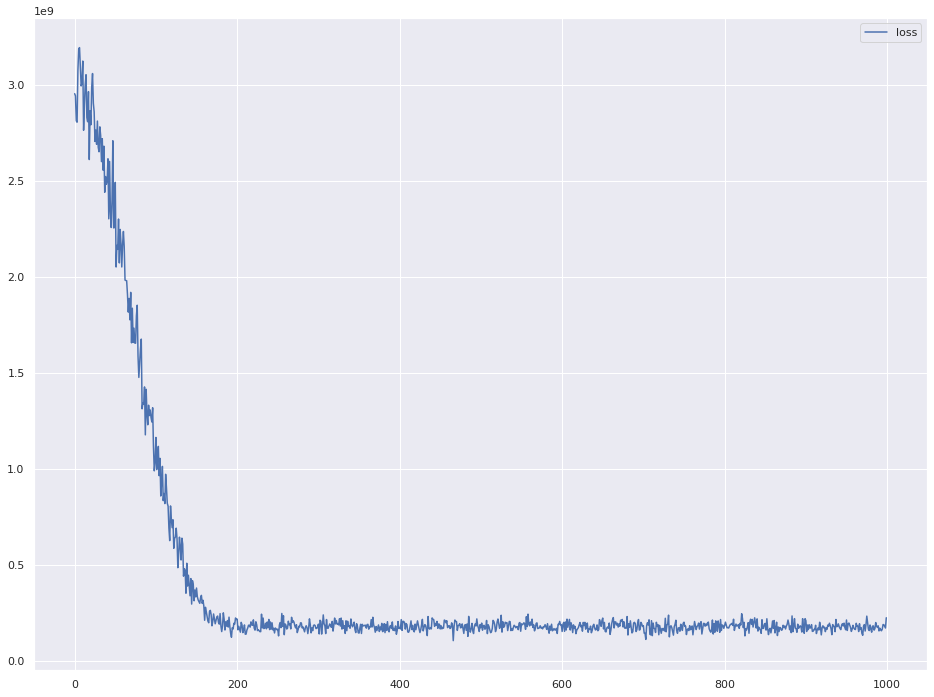

In [31]:
plot_history(history, offset=0, metrics=['loss'])

In [32]:
results = forecast(model)

ValueError: in user code:

    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)


# Addendum

In [33]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)


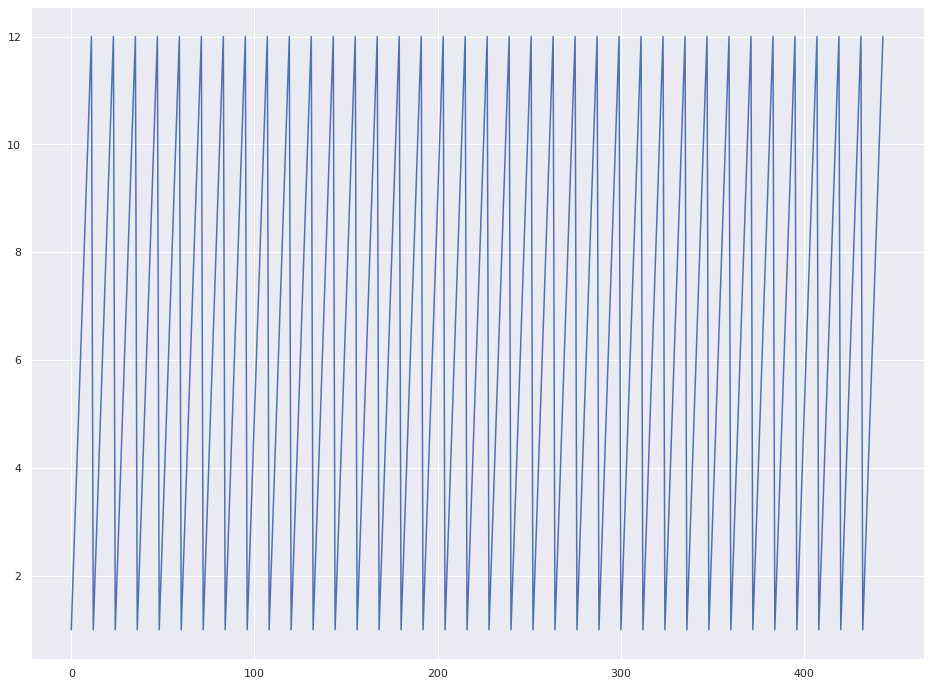

In [37]:
month = df.index.month
plt.plot(month)

In [38]:
month_sin = np.sin(2 * np.pi * month/12.0)
month_cos = np.cos(2 * np.pi * month/12.0)

In [63]:
df_t = df
df_t['month_sin'] = month_sin
df_t['month_cos'] = month_cos
df_t = df_t.set_index(df.index)
df = df_t

In [64]:
df

USA  Japan,South Korea    Eupora     month_sin     month_cos
Date                                                                         
1984-01-01  59191.20            3158.67  33524.59  5.000000e-01  8.660254e-01
1984-02-01  49898.24            2902.67  32041.52  8.660254e-01  5.000000e-01
1984-03-01  53440.16            3397.67  30465.52  1.000000e+00  6.123234e-17
1984-04-01  41004.24            3065.67  23029.52  8.660254e-01 -5.000000e-01
1984-05-01  35196.24            2932.67  19727.56  5.000000e-01 -8.660254e-01
...              ...                ...       ...           ...           ...
2020-08-01  65728.00           12880.00  28154.50 -8.660254e-01 -5.000000e-01
2020-09-01  57408.00           11753.00  32761.60 -1.000000e+00 -1.836970e-16
2020-10-01  61568.00           12075.00  37880.60 -8.660254e-01  5.000000e-01
2020-11-01  65728.00           13685.00  49142.40 -5.000000e-01  8.660254e-01
2020-12-01  86528.00           15617.00  57844.70 -2.449294e-16  1.000000e+00

[444 rows x 5 columns]

In [65]:
split_index = int(df.shape[0] * 0.8)

series = df['USA'].values
train_data = df['USA'][:split_index].values
test_data = df['USA'][split_index:].values

time_train = df['USA'][:split_index].index
time_test = df.index.values[split_index:]
x_valid = df['USA'][split_index:].values

dataset = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)
validation_ds = windowed_dataset(test_data, window_size, batch_size, shuffle_buffer_size)

In [66]:
model = tf.keras.models.Sequential([
    layers.Dense(32, input_shape=[window_size], activation='relu'), 
#     layers.Dropout(0.5),
    layers.Dense(32, activation='relu'), 
#     layers.Dropout(0.5),    
#     layers.Dense(32, activation='relu'), 
#     layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
history = model.fit(dataset, 
                    validation_data=validation_ds,
                    epochs=2500, verbose=1)

Epoch 1/2500
43/43 [==============================] - 0s 4ms/step - loss: 1209706946.9091 - val_loss: 122661688.0000
Epoch 2/2500
43/43 [==============================] - 0s 3ms/step - loss: 66099711.7273 - val_loss: 50085004.0000
Epoch 3/2500
43/43 [==============================] - 0s 3ms/step - loss: 26383646.1364 - val_loss: 29336460.0000
Epoch 4/2500
43/43 [==============================] - 0s 2ms/step - loss: 14470873.2955 - val_loss: 25827222.0000
Epoch 5/2500
43/43 [==============================] - 0s 3ms/step - loss: 13796780.7273 - val_loss: 22474144.0000
Epoch 6/2500
43/43 [==============================] - 0s 2ms/step - loss: 12624644.7273 - val_loss: 19501916.0000
Epoch 7/2500
43/43 [==============================] - 0s 3ms/step - loss: 10300420.3523 - val_loss: 17852588.0000
Epoch 8/2500
43/43 [==============================] - 0s 3ms/step - loss: 9532330.2386 - val_loss: 16554303.0000
Epoch 9/2500
43/43 [==============================] - 0s 3ms/step - loss: 9430751.8636

Epoch 73/2500
43/43 [==============================] - 0s 3ms/step - loss: 7265927.0682 - val_loss: 13707697.0000
Epoch 74/2500
43/43 [==============================] - 0s 2ms/step - loss: 9106005.1818 - val_loss: 11720129.0000
Epoch 75/2500
43/43 [==============================] - 0s 2ms/step - loss: 7597390.4886 - val_loss: 12948912.0000
Epoch 76/2500
43/43 [==============================] - 0s 3ms/step - loss: 8518245.0114 - val_loss: 11211030.0000
Epoch 77/2500
43/43 [==============================] - 0s 3ms/step - loss: 9581228.5455 - val_loss: 12103311.0000
Epoch 78/2500
43/43 [==============================] - 0s 3ms/step - loss: 7024887.9545 - val_loss: 11554729.0000
Epoch 79/2500
43/43 [==============================] - 0s 2ms/step - loss: 7570690.9091 - val_loss: 14006653.0000
Epoch 80/2500
43/43 [==============================] - 0s 2ms/step - loss: 8591405.6136 - val_loss: 15511067.0000
Epoch 81/2500
43/43 [==============================] - 0s 2ms/step - loss: 8439602.7727 

43/43 [==============================] - 0s 3ms/step - loss: 5918275.0568 - val_loss: 11081063.0000
Epoch 145/2500
43/43 [==============================] - 0s 3ms/step - loss: 7339773.5568 - val_loss: 9817794.0000
Epoch 146/2500
43/43 [==============================] - 0s 2ms/step - loss: 7421960.2273 - val_loss: 9902658.0000
Epoch 147/2500
43/43 [==============================] - 0s 3ms/step - loss: 5708078.6364 - val_loss: 13270514.0000
Epoch 148/2500
43/43 [==============================] - 0s 3ms/step - loss: 7136333.1932 - val_loss: 9723809.0000
Epoch 149/2500
43/43 [==============================] - 0s 3ms/step - loss: 6654621.1591 - val_loss: 10386804.0000
Epoch 150/2500
43/43 [==============================] - 0s 3ms/step - loss: 6060754.4716 - val_loss: 9639440.0000
Epoch 151/2500
43/43 [==============================] - 0s 3ms/step - loss: 8600832.3750 - val_loss: 12025982.0000
Epoch 152/2500
43/43 [==============================] - 0s 3ms/step - loss: 6756882.0000 - val_loss

43/43 [==============================] - 0s 3ms/step - loss: 6160859.4091 - val_loss: 15301782.0000
Epoch 216/2500
43/43 [==============================] - 0s 3ms/step - loss: 6212416.9034 - val_loss: 10642305.0000
Epoch 217/2500
43/43 [==============================] - 0s 4ms/step - loss: 5623445.5057 - val_loss: 13456599.0000
Epoch 218/2500
43/43 [==============================] - 0s 4ms/step - loss: 8111306.7045 - val_loss: 10769618.0000
Epoch 219/2500
43/43 [==============================] - 0s 3ms/step - loss: 6312500.3409 - val_loss: 13872995.0000
Epoch 220/2500
43/43 [==============================] - 0s 4ms/step - loss: 6788993.8295 - val_loss: 9557315.0000
Epoch 221/2500
43/43 [==============================] - 0s 2ms/step - loss: 5825950.5341 - val_loss: 11313612.0000
Epoch 222/2500
43/43 [==============================] - 0s 4ms/step - loss: 6823010.8466 - val_loss: 10540949.0000
Epoch 223/2500
43/43 [==============================] - 0s 2ms/step - loss: 5350501.1591 - val_l

43/43 [==============================] - 0s 3ms/step - loss: 6349655.5000 - val_loss: 9363398.0000
Epoch 287/2500
43/43 [==============================] - 0s 2ms/step - loss: 5856785.5170 - val_loss: 10244742.0000
Epoch 288/2500
43/43 [==============================] - 0s 2ms/step - loss: 6347757.6136 - val_loss: 11384401.0000
Epoch 289/2500
43/43 [==============================] - 0s 2ms/step - loss: 6519636.7159 - val_loss: 14124531.0000
Epoch 290/2500
43/43 [==============================] - 0s 2ms/step - loss: 7211505.5909 - val_loss: 12265093.0000
Epoch 291/2500
43/43 [==============================] - 0s 2ms/step - loss: 5191416.3920 - val_loss: 9547534.0000
Epoch 292/2500
43/43 [==============================] - 0s 2ms/step - loss: 5058645.0909 - val_loss: 9140685.0000
Epoch 293/2500
43/43 [==============================] - 0s 2ms/step - loss: 6575302.6250 - val_loss: 10058193.0000
Epoch 294/2500
43/43 [==============================] - 0s 3ms/step - loss: 6389156.0227 - val_los

43/43 [==============================] - 0s 3ms/step - loss: 6177077.9602 - val_loss: 9455249.0000
Epoch 358/2500
43/43 [==============================] - 0s 2ms/step - loss: 5387339.8409 - val_loss: 10762161.0000
Epoch 359/2500
43/43 [==============================] - 0s 2ms/step - loss: 6333798.9432 - val_loss: 9193934.0000
Epoch 360/2500
43/43 [==============================] - 0s 2ms/step - loss: 5685918.7045 - val_loss: 10087994.0000
Epoch 361/2500
43/43 [==============================] - 0s 3ms/step - loss: 5249679.3153 - val_loss: 10375871.0000
Epoch 362/2500
43/43 [==============================] - 0s 3ms/step - loss: 5084482.1705 - val_loss: 9231910.0000
Epoch 363/2500
43/43 [==============================] - 0s 3ms/step - loss: 5215619.7074 - val_loss: 9641768.0000
Epoch 364/2500
43/43 [==============================] - 0s 3ms/step - loss: 6329589.4432 - val_loss: 10149801.0000
Epoch 365/2500
43/43 [==============================] - 0s 3ms/step - loss: 5484419.7841 - val_loss

43/43 [==============================] - 0s 3ms/step - loss: 6174401.1307 - val_loss: 10242706.0000
Epoch 429/2500
43/43 [==============================] - 0s 2ms/step - loss: 5633480.2386 - val_loss: 11416623.0000
Epoch 430/2500
43/43 [==============================] - 0s 2ms/step - loss: 6780187.0909 - val_loss: 9750040.0000
Epoch 431/2500
43/43 [==============================] - 0s 2ms/step - loss: 5268513.5455 - val_loss: 9752204.0000
Epoch 432/2500
43/43 [==============================] - 0s 3ms/step - loss: 6212820.8636 - val_loss: 9911806.0000
Epoch 433/2500
43/43 [==============================] - 0s 2ms/step - loss: 5221744.5739 - val_loss: 10668218.0000
Epoch 434/2500
43/43 [==============================] - 0s 2ms/step - loss: 5238579.3920 - val_loss: 16145438.0000
Epoch 435/2500
43/43 [==============================] - 0s 2ms/step - loss: 6406557.0455 - val_loss: 8358982.0000
Epoch 436/2500
43/43 [==============================] - 0s 2ms/step - loss: 6053600.3864 - val_loss

Epoch 500/2500
43/43 [==============================] - 0s 2ms/step - loss: 6475045.8523 - val_loss: 10192635.0000
Epoch 501/2500
43/43 [==============================] - 0s 2ms/step - loss: 5637201.1136 - val_loss: 10131986.0000
Epoch 502/2500
43/43 [==============================] - 0s 2ms/step - loss: 4950345.9290 - val_loss: 9915080.0000
Epoch 503/2500
43/43 [==============================] - 0s 2ms/step - loss: 7465187.1023 - val_loss: 9628949.0000
Epoch 504/2500
43/43 [==============================] - 0s 2ms/step - loss: 4810335.9886 - val_loss: 9901467.0000
Epoch 505/2500
43/43 [==============================] - 0s 2ms/step - loss: 6150281.9432 - val_loss: 10154937.0000
Epoch 506/2500
43/43 [==============================] - 0s 2ms/step - loss: 5223457.1875 - val_loss: 17212962.0000
Epoch 507/2500
43/43 [==============================] - 0s 2ms/step - loss: 7214908.5000 - val_loss: 13484840.0000
Epoch 508/2500
43/43 [==============================] - 0s 2ms/step - loss: 6621750

43/43 [==============================] - 0s 2ms/step - loss: 5100884.9261 - val_loss: 8412045.0000
Epoch 572/2500
43/43 [==============================] - 0s 2ms/step - loss: 5626630.8409 - val_loss: 8774506.0000
Epoch 573/2500
43/43 [==============================] - 0s 2ms/step - loss: 5568924.7330 - val_loss: 8872625.0000
Epoch 574/2500
43/43 [==============================] - 0s 2ms/step - loss: 5982668.8750 - val_loss: 9903748.0000
Epoch 575/2500
43/43 [==============================] - 0s 2ms/step - loss: 5215573.6591 - val_loss: 8757844.0000
Epoch 576/2500
43/43 [==============================] - 0s 2ms/step - loss: 5437820.6080 - val_loss: 9782328.0000
Epoch 577/2500
43/43 [==============================] - 0s 2ms/step - loss: 5150898.8864 - val_loss: 8389062.0000
Epoch 578/2500
43/43 [==============================] - 0s 3ms/step - loss: 5191695.2386 - val_loss: 10258233.0000
Epoch 579/2500
43/43 [==============================] - 0s 2ms/step - loss: 7051990.9091 - val_loss: 1

Epoch 643/2500
43/43 [==============================] - 0s 2ms/step - loss: 5046694.8466 - val_loss: 9453383.0000
Epoch 644/2500
43/43 [==============================] - 0s 2ms/step - loss: 6782141.8750 - val_loss: 9305192.0000
Epoch 645/2500
43/43 [==============================] - 0s 2ms/step - loss: 5543217.9545 - val_loss: 9251113.0000
Epoch 646/2500
43/43 [==============================] - 0s 2ms/step - loss: 5287706.8295 - val_loss: 9182415.0000
Epoch 647/2500
43/43 [==============================] - 0s 2ms/step - loss: 6073891.3977 - val_loss: 9580133.0000
Epoch 648/2500
43/43 [==============================] - 0s 2ms/step - loss: 5552267.8409 - val_loss: 8584486.0000
Epoch 649/2500
43/43 [==============================] - 0s 2ms/step - loss: 4703205.1080 - val_loss: 9411334.0000
Epoch 650/2500
43/43 [==============================] - 0s 2ms/step - loss: 5817023.1250 - val_loss: 11063673.0000
Epoch 651/2500
43/43 [==============================] - 0s 3ms/step - loss: 5394423.846

43/43 [==============================] - 0s 2ms/step - loss: 5423885.1364 - val_loss: 8391522.0000
Epoch 715/2500
43/43 [==============================] - 0s 2ms/step - loss: 4308833.8466 - val_loss: 8825643.0000
Epoch 716/2500
43/43 [==============================] - 0s 2ms/step - loss: 4943480.7386 - val_loss: 11008348.0000
Epoch 717/2500
43/43 [==============================] - 0s 2ms/step - loss: 5521048.8636 - val_loss: 9170904.0000
Epoch 718/2500
43/43 [==============================] - 0s 3ms/step - loss: 5378317.1705 - val_loss: 10084883.0000
Epoch 719/2500
43/43 [==============================] - 0s 3ms/step - loss: 5999418.8750 - val_loss: 10154632.0000
Epoch 720/2500
43/43 [==============================] - 0s 2ms/step - loss: 7236523.4432 - val_loss: 9571299.0000
Epoch 721/2500
43/43 [==============================] - 0s 2ms/step - loss: 4511576.6818 - val_loss: 10111663.0000
Epoch 722/2500
43/43 [==============================] - 0s 2ms/step - loss: 4895062.0795 - val_loss

Epoch 786/2500
43/43 [==============================] - 0s 3ms/step - loss: 4651540.9432 - val_loss: 8885920.0000
Epoch 787/2500
43/43 [==============================] - 0s 3ms/step - loss: 4571499.1364 - val_loss: 8581342.0000
Epoch 788/2500
43/43 [==============================] - 0s 3ms/step - loss: 4972251.7330 - val_loss: 9030722.0000
Epoch 789/2500
43/43 [==============================] - 0s 3ms/step - loss: 4777200.8750 - val_loss: 9089275.0000
Epoch 790/2500
43/43 [==============================] - 0s 2ms/step - loss: 4956468.3636 - val_loss: 11910251.0000
Epoch 791/2500
43/43 [==============================] - 0s 3ms/step - loss: 5156399.2500 - val_loss: 8871153.0000
Epoch 792/2500
43/43 [==============================] - 0s 2ms/step - loss: 4545333.3920 - val_loss: 10366290.0000
Epoch 793/2500
43/43 [==============================] - 0s 4ms/step - loss: 5340182.4773 - val_loss: 10657268.0000
Epoch 794/2500
43/43 [==============================] - 0s 4ms/step - loss: 5461454.2

43/43 [==============================] - 0s 3ms/step - loss: 4597301.3636 - val_loss: 9828659.0000
Epoch 858/2500
43/43 [==============================] - 0s 3ms/step - loss: 4996161.5511 - val_loss: 12317961.0000
Epoch 859/2500
43/43 [==============================] - 0s 3ms/step - loss: 4117585.2216 - val_loss: 9381236.0000
Epoch 860/2500
43/43 [==============================] - 0s 3ms/step - loss: 3930753.9261 - val_loss: 9841154.0000
Epoch 861/2500
43/43 [==============================] - 0s 3ms/step - loss: 5233923.7614 - val_loss: 8964140.0000
Epoch 862/2500
43/43 [==============================] - 0s 4ms/step - loss: 5677335.3182 - val_loss: 8944845.0000
Epoch 863/2500
43/43 [==============================] - 0s 2ms/step - loss: 4110371.6818 - val_loss: 9310911.0000
Epoch 864/2500
43/43 [==============================] - 0s 2ms/step - loss: 5271435.9545 - val_loss: 7794204.5000
Epoch 865/2500
43/43 [==============================] - 0s 3ms/step - loss: 5216206.5000 - val_loss: 9

Epoch 929/2500
43/43 [==============================] - 0s 2ms/step - loss: 3966017.6818 - val_loss: 10985796.0000
Epoch 930/2500
43/43 [==============================] - 0s 2ms/step - loss: 4265185.4432 - val_loss: 11583489.0000
Epoch 931/2500
43/43 [==============================] - 0s 2ms/step - loss: 5599709.0341 - val_loss: 9620934.0000
Epoch 932/2500
43/43 [==============================] - 0s 2ms/step - loss: 4548927.0312 - val_loss: 9361034.0000
Epoch 933/2500
43/43 [==============================] - 0s 2ms/step - loss: 4692940.4233 - val_loss: 9067064.0000
Epoch 934/2500
43/43 [==============================] - 0s 2ms/step - loss: 4190731.0114 - val_loss: 8514562.0000
Epoch 935/2500
43/43 [==============================] - 0s 2ms/step - loss: 4083567.2500 - val_loss: 9239120.0000
Epoch 936/2500
43/43 [==============================] - 0s 2ms/step - loss: 5063648.8523 - val_loss: 8490508.0000
Epoch 937/2500
43/43 [==============================] - 0s 2ms/step - loss: 4874452.99

Epoch 1001/2500
43/43 [==============================] - 0s 2ms/step - loss: 4388023.3352 - val_loss: 8866070.0000
Epoch 1002/2500
43/43 [==============================] - 0s 2ms/step - loss: 4778841.3523 - val_loss: 10188748.0000
Epoch 1003/2500
43/43 [==============================] - 0s 2ms/step - loss: 3979378.4773 - val_loss: 8057937.5000
Epoch 1004/2500
43/43 [==============================] - 0s 2ms/step - loss: 3628121.5227 - val_loss: 10301150.0000
Epoch 1005/2500
43/43 [==============================] - 0s 2ms/step - loss: 5347152.7955 - val_loss: 8194859.0000
Epoch 1006/2500
43/43 [==============================] - 0s 2ms/step - loss: 4976663.3636 - val_loss: 8585975.0000
Epoch 1007/2500
43/43 [==============================] - 0s 2ms/step - loss: 5062037.9943 - val_loss: 10144071.0000
Epoch 1008/2500
43/43 [==============================] - 0s 2ms/step - loss: 5522673.4886 - val_loss: 9077660.0000
Epoch 1009/2500
43/43 [==============================] - 0s 2ms/step - loss: 

43/43 [==============================] - 0s 2ms/step - loss: 4514804.4886 - val_loss: 10808899.0000
Epoch 1073/2500
43/43 [==============================] - 0s 2ms/step - loss: 4629586.4602 - val_loss: 8114577.5000
Epoch 1074/2500
43/43 [==============================] - 0s 3ms/step - loss: 4828358.4659 - val_loss: 9078966.0000
Epoch 1075/2500
43/43 [==============================] - 0s 2ms/step - loss: 5584286.0227 - val_loss: 9513575.0000
Epoch 1076/2500
43/43 [==============================] - 0s 2ms/step - loss: 5455456.6364 - val_loss: 9620134.0000
Epoch 1077/2500
43/43 [==============================] - 0s 2ms/step - loss: 4734914.0398 - val_loss: 9286187.0000
Epoch 1078/2500
43/43 [==============================] - 0s 2ms/step - loss: 4201234.2386 - val_loss: 8438173.0000
Epoch 1079/2500
43/43 [==============================] - 0s 3ms/step - loss: 4971894.9602 - val_loss: 9058183.0000
Epoch 1080/2500
43/43 [==============================] - 0s 2ms/step - loss: 4515384.2273 - val

43/43 [==============================] - 0s 2ms/step - loss: 4337404.6705 - val_loss: 8578687.0000
Epoch 1144/2500
43/43 [==============================] - 0s 2ms/step - loss: 4358311.4545 - val_loss: 10407114.0000
Epoch 1145/2500
43/43 [==============================] - 0s 2ms/step - loss: 4697827.5227 - val_loss: 9438767.0000
Epoch 1146/2500
43/43 [==============================] - 0s 2ms/step - loss: 3688070.4034 - val_loss: 9639590.0000
Epoch 1147/2500
43/43 [==============================] - 0s 2ms/step - loss: 4357339.0284 - val_loss: 10540204.0000
Epoch 1148/2500
43/43 [==============================] - 0s 2ms/step - loss: 3914398.1420 - val_loss: 9946186.0000
Epoch 1149/2500
43/43 [==============================] - 0s 2ms/step - loss: 4650801.3977 - val_loss: 9721054.0000
Epoch 1150/2500
43/43 [==============================] - 0s 2ms/step - loss: 4434938.9631 - val_loss: 10076138.0000
Epoch 1151/2500
43/43 [==============================] - 0s 2ms/step - loss: 3984611.2841 - v

43/43 [==============================] - 0s 3ms/step - loss: 4630839.4318 - val_loss: 9689218.0000
Epoch 1215/2500
43/43 [==============================] - 0s 3ms/step - loss: 4500408.9205 - val_loss: 8786425.0000
Epoch 1216/2500
43/43 [==============================] - 0s 3ms/step - loss: 4362717.3693 - val_loss: 9383220.0000
Epoch 1217/2500
43/43 [==============================] - 0s 3ms/step - loss: 4242222.2216 - val_loss: 9603471.0000
Epoch 1218/2500
43/43 [==============================] - 0s 3ms/step - loss: 4657397.2188 - val_loss: 9456824.0000
Epoch 1219/2500
43/43 [==============================] - 0s 2ms/step - loss: 5359120.0398 - val_loss: 9507402.0000
Epoch 1220/2500
43/43 [==============================] - 0s 2ms/step - loss: 4368979.3977 - val_loss: 8905856.0000
Epoch 1221/2500
43/43 [==============================] - 0s 3ms/step - loss: 3368641.8381 - val_loss: 9801270.0000
Epoch 1222/2500
43/43 [==============================] - 0s 3ms/step - loss: 3222448.1449 - val_

43/43 [==============================] - 0s 2ms/step - loss: 3122134.7102 - val_loss: 9697100.0000
Epoch 1286/2500
43/43 [==============================] - 0s 3ms/step - loss: 4066058.8693 - val_loss: 8729390.0000
Epoch 1287/2500
43/43 [==============================] - 0s 3ms/step - loss: 3272164.6307 - val_loss: 9918882.0000
Epoch 1288/2500
43/43 [==============================] - 0s 3ms/step - loss: 4184409.0511 - val_loss: 9950929.0000
Epoch 1289/2500
43/43 [==============================] - 0s 3ms/step - loss: 4680206.5284 - val_loss: 13169637.0000
Epoch 1290/2500
43/43 [==============================] - 0s 2ms/step - loss: 4097269.9375 - val_loss: 12264391.0000
Epoch 1291/2500
43/43 [==============================] - 0s 2ms/step - loss: 5009144.6477 - val_loss: 10732433.0000
Epoch 1292/2500
43/43 [==============================] - 0s 2ms/step - loss: 3582548.1790 - val_loss: 9924232.0000
Epoch 1293/2500
43/43 [==============================] - 0s 2ms/step - loss: 4625715.2614 - v

43/43 [==============================] - 0s 2ms/step - loss: 3445464.6761 - val_loss: 9148916.0000
Epoch 1357/2500
43/43 [==============================] - 0s 2ms/step - loss: 3671038.6989 - val_loss: 10764199.0000
Epoch 1358/2500
43/43 [==============================] - 0s 2ms/step - loss: 3625181.3636 - val_loss: 12455239.0000
Epoch 1359/2500
43/43 [==============================] - 0s 3ms/step - loss: 6271937.3977 - val_loss: 9890906.0000
Epoch 1360/2500
43/43 [==============================] - 0s 3ms/step - loss: 3938387.8977 - val_loss: 11303773.0000
Epoch 1361/2500
43/43 [==============================] - 0s 3ms/step - loss: 4872220.6136 - val_loss: 9594296.0000
Epoch 1362/2500
43/43 [==============================] - 0s 2ms/step - loss: 4168530.2670 - val_loss: 10671657.0000
Epoch 1363/2500
43/43 [==============================] - 0s 2ms/step - loss: 3336176.4290 - val_loss: 9909698.0000
Epoch 1364/2500
43/43 [==============================] - 0s 2ms/step - loss: 4309399.6705 - 

43/43 [==============================] - 0s 2ms/step - loss: 3395039.2159 - val_loss: 9980993.0000
Epoch 1428/2500
43/43 [==============================] - 0s 2ms/step - loss: 3524763.8068 - val_loss: 8954689.0000
Epoch 1429/2500
43/43 [==============================] - 0s 2ms/step - loss: 4683555.6761 - val_loss: 9764668.0000
Epoch 1430/2500
43/43 [==============================] - 0s 2ms/step - loss: 3787168.1591 - val_loss: 12906343.0000
Epoch 1431/2500
43/43 [==============================] - 0s 2ms/step - loss: 4083030.3750 - val_loss: 10513342.0000
Epoch 1432/2500
43/43 [==============================] - 0s 2ms/step - loss: 4412178.0057 - val_loss: 10718732.0000
Epoch 1433/2500
43/43 [==============================] - 0s 3ms/step - loss: 3264772.5795 - val_loss: 9903641.0000
Epoch 1434/2500
43/43 [==============================] - 0s 3ms/step - loss: 4152940.4318 - val_loss: 11120545.0000
Epoch 1435/2500
43/43 [==============================] - 0s 3ms/step - loss: 4265458.4375 - 

43/43 [==============================] - 0s 3ms/step - loss: 3321306.1051 - val_loss: 9832977.0000
Epoch 1499/2500
43/43 [==============================] - 0s 3ms/step - loss: 4585706.5227 - val_loss: 10179385.0000
Epoch 1500/2500
43/43 [==============================] - 0s 3ms/step - loss: 4707071.8068 - val_loss: 10367215.0000
Epoch 1501/2500
43/43 [==============================] - 0s 3ms/step - loss: 3940640.9773 - val_loss: 9124625.0000
Epoch 1502/2500
43/43 [==============================] - 0s 3ms/step - loss: 3879584.4290 - val_loss: 11485319.0000
Epoch 1503/2500
43/43 [==============================] - 0s 2ms/step - loss: 3896815.6648 - val_loss: 12506555.0000
Epoch 1504/2500
43/43 [==============================] - 0s 2ms/step - loss: 4266194.7841 - val_loss: 9776071.0000
Epoch 1505/2500
43/43 [==============================] - 0s 2ms/step - loss: 3320720.7159 - val_loss: 15384456.0000
Epoch 1506/2500
43/43 [==============================] - 0s 2ms/step - loss: 4751289.6136 -

43/43 [==============================] - 0s 2ms/step - loss: 3535793.7386 - val_loss: 9345884.0000
Epoch 1570/2500
43/43 [==============================] - 0s 2ms/step - loss: 3235725.2614 - val_loss: 9642379.0000
Epoch 1571/2500
43/43 [==============================] - 0s 2ms/step - loss: 3374739.2443 - val_loss: 9623022.0000
Epoch 1572/2500
43/43 [==============================] - 0s 2ms/step - loss: 3081433.1136 - val_loss: 11156534.0000
Epoch 1573/2500
43/43 [==============================] - 0s 2ms/step - loss: 3766849.8125 - val_loss: 10819486.0000
Epoch 1574/2500
43/43 [==============================] - 0s 2ms/step - loss: 3918281.4318 - val_loss: 12515229.0000
Epoch 1575/2500
43/43 [==============================] - 0s 2ms/step - loss: 4430034.6989 - val_loss: 12004648.0000
Epoch 1576/2500
43/43 [==============================] - 0s 2ms/step - loss: 4063908.4318 - val_loss: 9552707.0000
Epoch 1577/2500
43/43 [==============================] - 0s 2ms/step - loss: 4412180.1477 - 

Epoch 1640/2500
43/43 [==============================] - 0s 2ms/step - loss: 2911341.8182 - val_loss: 13145756.0000
Epoch 1641/2500
43/43 [==============================] - 0s 2ms/step - loss: 3462767.5795 - val_loss: 9734837.0000
Epoch 1642/2500
43/43 [==============================] - 0s 2ms/step - loss: 4016381.6080 - val_loss: 11056199.0000
Epoch 1643/2500
43/43 [==============================] - 0s 2ms/step - loss: 4425943.8352 - val_loss: 9805356.0000
Epoch 1644/2500
43/43 [==============================] - 0s 2ms/step - loss: 3159213.0142 - val_loss: 9977111.0000
Epoch 1645/2500
43/43 [==============================] - 0s 2ms/step - loss: 3439419.9773 - val_loss: 10164836.0000
Epoch 1646/2500
43/43 [==============================] - 0s 2ms/step - loss: 3333984.5114 - val_loss: 10722183.0000
Epoch 1647/2500
43/43 [==============================] - 0s 2ms/step - loss: 3490930.9489 - val_loss: 12331085.0000
Epoch 1648/2500
43/43 [==============================] - 0s 2ms/step - loss

Epoch 1711/2500
43/43 [==============================] - 0s 2ms/step - loss: 3669889.0170 - val_loss: 10452881.0000
Epoch 1712/2500
43/43 [==============================] - 0s 2ms/step - loss: 3437952.4233 - val_loss: 10130754.0000
Epoch 1713/2500
43/43 [==============================] - 0s 3ms/step - loss: 3072937.3693 - val_loss: 10451959.0000
Epoch 1714/2500
43/43 [==============================] - 0s 2ms/step - loss: 3153673.9943 - val_loss: 10557568.0000
Epoch 1715/2500
43/43 [==============================] - 0s 2ms/step - loss: 3678505.1648 - val_loss: 12929728.0000
Epoch 1716/2500
43/43 [==============================] - 0s 2ms/step - loss: 4014019.7216 - val_loss: 10021697.0000
Epoch 1717/2500
43/43 [==============================] - 0s 3ms/step - loss: 3364818.8523 - val_loss: 9942683.0000
Epoch 1718/2500
43/43 [==============================] - 0s 2ms/step - loss: 3598478.8693 - val_loss: 10266764.0000
Epoch 1719/2500
43/43 [==============================] - 0s 2ms/step - lo

Epoch 1782/2500
43/43 [==============================] - 0s 2ms/step - loss: 3535908.3864 - val_loss: 10530477.0000
Epoch 1783/2500
43/43 [==============================] - 0s 2ms/step - loss: 4200834.2898 - val_loss: 10631021.0000
Epoch 1784/2500
43/43 [==============================] - 0s 3ms/step - loss: 4269557.6136 - val_loss: 12320283.0000
Epoch 1785/2500
43/43 [==============================] - 0s 4ms/step - loss: 3357667.5966 - val_loss: 12510015.0000
Epoch 1786/2500
43/43 [==============================] - 0s 3ms/step - loss: 2957898.6705 - val_loss: 10782677.0000
Epoch 1787/2500
43/43 [==============================] - 0s 3ms/step - loss: 3930769.0114 - val_loss: 10465857.0000
Epoch 1788/2500
43/43 [==============================] - 0s 3ms/step - loss: 3893637.5994 - val_loss: 12229059.0000
Epoch 1789/2500
43/43 [==============================] - 0s 3ms/step - loss: 3976149.8409 - val_loss: 9156624.0000
Epoch 1790/2500
43/43 [==============================] - 0s 3ms/step - lo

Epoch 1853/2500
43/43 [==============================] - 0s 3ms/step - loss: 3182071.5114 - val_loss: 10249837.0000
Epoch 1854/2500
43/43 [==============================] - 0s 2ms/step - loss: 2851360.7500 - val_loss: 11861499.0000
Epoch 1855/2500
43/43 [==============================] - 0s 2ms/step - loss: 2946239.2386 - val_loss: 10795040.0000
Epoch 1856/2500
43/43 [==============================] - 0s 2ms/step - loss: 3175479.6591 - val_loss: 10319775.0000
Epoch 1857/2500
43/43 [==============================] - 0s 2ms/step - loss: 4262333.4830 - val_loss: 10432209.0000
Epoch 1858/2500
43/43 [==============================] - 0s 2ms/step - loss: 4033970.7784 - val_loss: 10320561.0000
Epoch 1859/2500
43/43 [==============================] - 0s 2ms/step - loss: 4516154.5682 - val_loss: 9894594.0000
Epoch 1860/2500
43/43 [==============================] - 0s 2ms/step - loss: 2988400.3892 - val_loss: 9926180.0000
Epoch 1861/2500
43/43 [==============================] - 0s 2ms/step - los

43/43 [==============================] - 0s 2ms/step - loss: 3285397.2727 - val_loss: 9984670.0000
Epoch 1924/2500
43/43 [==============================] - 0s 2ms/step - loss: 2953897.3097 - val_loss: 9759713.0000
Epoch 1925/2500
43/43 [==============================] - 0s 2ms/step - loss: 3289910.9375 - val_loss: 11417044.0000
Epoch 1926/2500
43/43 [==============================] - 0s 2ms/step - loss: 3354916.6335 - val_loss: 10623422.0000
Epoch 1927/2500
43/43 [==============================] - 0s 2ms/step - loss: 3068512.5341 - val_loss: 9703561.0000
Epoch 1928/2500
43/43 [==============================] - 0s 2ms/step - loss: 2981986.2244 - val_loss: 10942358.0000
Epoch 1929/2500
43/43 [==============================] - 0s 2ms/step - loss: 3565600.9091 - val_loss: 12845212.0000
Epoch 1930/2500
43/43 [==============================] - 0s 2ms/step - loss: 3221702.5114 - val_loss: 15368122.0000
Epoch 1931/2500
43/43 [==============================] - 0s 2ms/step - loss: 3968821.7443 -

Epoch 1994/2500
43/43 [==============================] - 0s 3ms/step - loss: 3800442.7188 - val_loss: 11780400.0000
Epoch 1995/2500
43/43 [==============================] - 0s 2ms/step - loss: 3253048.9375 - val_loss: 9771653.0000
Epoch 1996/2500
43/43 [==============================] - 0s 3ms/step - loss: 3517829.0284 - val_loss: 12026669.0000
Epoch 1997/2500
43/43 [==============================] - 0s 3ms/step - loss: 3829934.2898 - val_loss: 11325319.0000
Epoch 1998/2500
43/43 [==============================] - 0s 2ms/step - loss: 3941081.4830 - val_loss: 10374954.0000
Epoch 1999/2500
43/43 [==============================] - 0s 3ms/step - loss: 3092799.2273 - val_loss: 9868502.0000
Epoch 2000/2500
43/43 [==============================] - 0s 2ms/step - loss: 2828762.3636 - val_loss: 12182435.0000
Epoch 2001/2500
43/43 [==============================] - 0s 3ms/step - loss: 3396886.1960 - val_loss: 10119045.0000
Epoch 2002/2500
43/43 [==============================] - 0s 3ms/step - los

43/43 [==============================] - 0s 3ms/step - loss: 3075565.2898 - val_loss: 10453467.0000
Epoch 2065/2500
43/43 [==============================] - 0s 3ms/step - loss: 3143108.0511 - val_loss: 10532857.0000
Epoch 2066/2500
43/43 [==============================] - 0s 3ms/step - loss: 3269363.0568 - val_loss: 10928797.0000
Epoch 2067/2500
43/43 [==============================] - 0s 3ms/step - loss: 2599262.3771 - val_loss: 10526234.0000
Epoch 2068/2500
43/43 [==============================] - 0s 2ms/step - loss: 2892822.7983 - val_loss: 10969268.0000
Epoch 2069/2500
43/43 [==============================] - 0s 2ms/step - loss: 3915503.9318 - val_loss: 11365789.0000
Epoch 2070/2500
43/43 [==============================] - 0s 2ms/step - loss: 3064258.4375 - val_loss: 10685297.0000
Epoch 2071/2500
43/43 [==============================] - 0s 2ms/step - loss: 4345768.6420 - val_loss: 11574643.0000
Epoch 2072/2500
43/43 [==============================] - 0s 2ms/step - loss: 2744719.099

Epoch 2135/2500
43/43 [==============================] - 0s 2ms/step - loss: 3120237.6875 - val_loss: 13071722.0000
Epoch 2136/2500
43/43 [==============================] - 0s 2ms/step - loss: 3190921.2045 - val_loss: 9738808.0000
Epoch 2137/2500
43/43 [==============================] - 0s 2ms/step - loss: 2547695.9659 - val_loss: 21387840.0000
Epoch 2138/2500
43/43 [==============================] - 0s 2ms/step - loss: 4735266.3068 - val_loss: 11423087.0000
Epoch 2139/2500
43/43 [==============================] - 0s 2ms/step - loss: 3053455.5000 - val_loss: 10954193.0000
Epoch 2140/2500
43/43 [==============================] - 0s 2ms/step - loss: 3589598.3864 - val_loss: 12039954.0000
Epoch 2141/2500
43/43 [==============================] - 0s 2ms/step - loss: 3727846.6705 - val_loss: 10544187.0000
Epoch 2142/2500
43/43 [==============================] - 0s 2ms/step - loss: 3411387.2273 - val_loss: 10926176.0000
Epoch 2143/2500
43/43 [==============================] - 0s 2ms/step - lo

43/43 [==============================] - 0s 2ms/step - loss: 4746026.4091 - val_loss: 10804087.0000
Epoch 2206/2500
43/43 [==============================] - 0s 2ms/step - loss: 3531159.4659 - val_loss: 13685473.0000
Epoch 2207/2500
43/43 [==============================] - 0s 2ms/step - loss: 3930022.1250 - val_loss: 11013075.0000
Epoch 2208/2500
43/43 [==============================] - 0s 2ms/step - loss: 2423933.7045 - val_loss: 11028879.0000
Epoch 2209/2500
43/43 [==============================] - 0s 2ms/step - loss: 2128230.7955 - val_loss: 12013901.0000
Epoch 2210/2500
43/43 [==============================] - 0s 2ms/step - loss: 2373890.3565 - val_loss: 10426571.0000
Epoch 2211/2500
43/43 [==============================] - 0s 2ms/step - loss: 2847675.4688 - val_loss: 15809965.0000
Epoch 2212/2500
43/43 [==============================] - 0s 2ms/step - loss: 2964832.6193 - val_loss: 10714345.0000
Epoch 2213/2500
43/43 [==============================] - 0s 2ms/step - loss: 2558987.113

Epoch 2276/2500
43/43 [==============================] - 0s 2ms/step - loss: 2580641.0426 - val_loss: 11914686.0000
Epoch 2277/2500
43/43 [==============================] - 0s 2ms/step - loss: 2888068.6136 - val_loss: 10825543.0000
Epoch 2278/2500
43/43 [==============================] - 0s 2ms/step - loss: 2743975.5284 - val_loss: 10529420.0000
Epoch 2279/2500
43/43 [==============================] - 0s 2ms/step - loss: 2298574.0767 - val_loss: 10959623.0000
Epoch 2280/2500
43/43 [==============================] - 0s 2ms/step - loss: 2695283.0114 - val_loss: 11065601.0000
Epoch 2281/2500
43/43 [==============================] - 0s 2ms/step - loss: 2875030.3920 - val_loss: 13268143.0000
Epoch 2282/2500
43/43 [==============================] - 0s 2ms/step - loss: 3063362.7841 - val_loss: 12030512.0000
Epoch 2283/2500
43/43 [==============================] - 0s 2ms/step - loss: 3138774.2216 - val_loss: 12623133.0000
Epoch 2284/2500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 3566830.8239 - val_loss: 11425603.0000
Epoch 2347/2500
43/43 [==============================] - 0s 2ms/step - loss: 2589865.5568 - val_loss: 11241164.0000
Epoch 2348/2500
43/43 [==============================] - 0s 2ms/step - loss: 2739387.5227 - val_loss: 12108753.0000
Epoch 2349/2500
43/43 [==============================] - 0s 2ms/step - loss: 2824997.1676 - val_loss: 10555004.0000
Epoch 2350/2500
43/43 [==============================] - 0s 2ms/step - loss: 2778775.7216 - val_loss: 12180345.0000
Epoch 2351/2500
43/43 [==============================] - 0s 2ms/step - loss: 2707817.9347 - val_loss: 11789906.0000
Epoch 2352/2500
43/43 [==============================] - 0s 2ms/step - loss: 3165237.7557 - val_loss: 11308788.0000
Epoch 2353/2500
43/43 [==============================] - 0s 2ms/step - loss: 2678830.5312 - val_loss: 13557795.0000
Epoch 2354/2500
43/43 [==============================] - 0s 2ms/step - loss: 2367111.119

Epoch 2417/2500
43/43 [==============================] - 0s 2ms/step - loss: 2478977.8068 - val_loss: 12088421.0000
Epoch 2418/2500
43/43 [==============================] - 0s 2ms/step - loss: 2830236.1307 - val_loss: 10285380.0000
Epoch 2419/2500
43/43 [==============================] - 0s 2ms/step - loss: 2285191.4602 - val_loss: 12427202.0000
Epoch 2420/2500
43/43 [==============================] - 0s 2ms/step - loss: 3144947.4602 - val_loss: 10737415.0000
Epoch 2421/2500
43/43 [==============================] - 0s 2ms/step - loss: 2236513.0455 - val_loss: 12114165.0000
Epoch 2422/2500
43/43 [==============================] - 0s 2ms/step - loss: 2474572.8040 - val_loss: 10520724.0000
Epoch 2423/2500
43/43 [==============================] - 0s 2ms/step - loss: 2857543.5312 - val_loss: 10812203.0000
Epoch 2424/2500
43/43 [==============================] - 0s 2ms/step - loss: 2818993.7500 - val_loss: 12223929.0000
Epoch 2425/2500
43/43 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 3ms/step - loss: 2426045.6080 - val_loss: 11857796.0000
Epoch 2488/2500
43/43 [==============================] - 0s 3ms/step - loss: 3303907.6506 - val_loss: 12972673.0000
Epoch 2489/2500
43/43 [==============================] - 0s 3ms/step - loss: 2622971.1449 - val_loss: 11836222.0000
Epoch 2490/2500
43/43 [==============================] - 0s 3ms/step - loss: 3977940.0455 - val_loss: 14229544.0000
Epoch 2491/2500
43/43 [==============================] - 0s 3ms/step - loss: 4362585.9148 - val_loss: 12318173.0000
Epoch 2492/2500
43/43 [==============================] - 0s 3ms/step - loss: 3349752.6420 - val_loss: 11253207.0000
Epoch 2493/2500
43/43 [==============================] - 0s 3ms/step - loss: 2167184.4460 - val_loss: 10809124.0000
Epoch 2494/2500
43/43 [==============================] - 0s 3ms/step - loss: 2979386.5852 - val_loss: 10563275.0000
Epoch 2495/2500
43/43 [==============================] - 0s 3ms/step - loss: 2307319.786

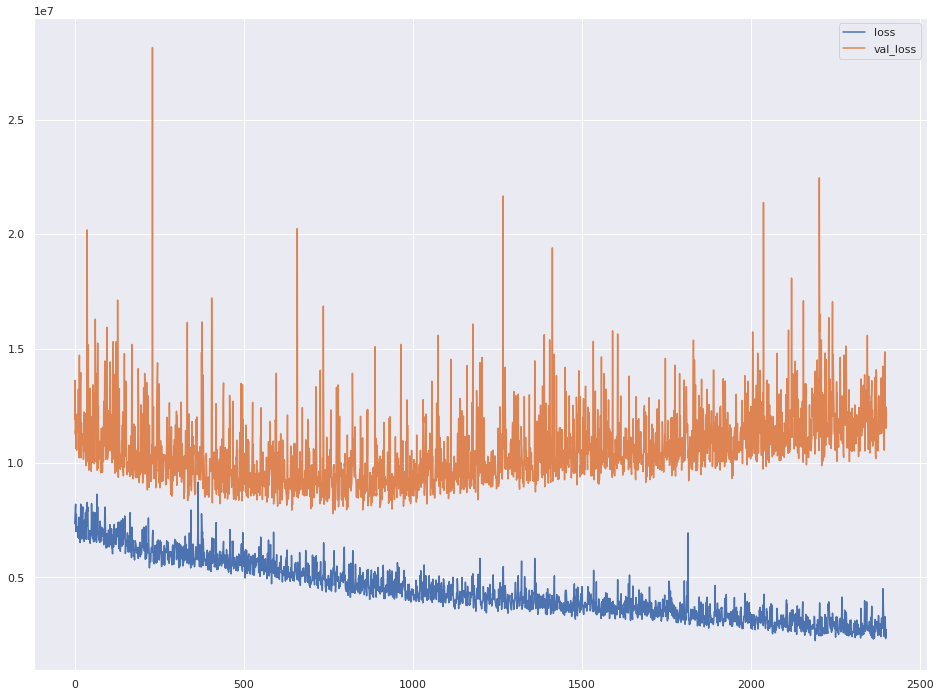

In [67]:
plot_history(history, offset=100)

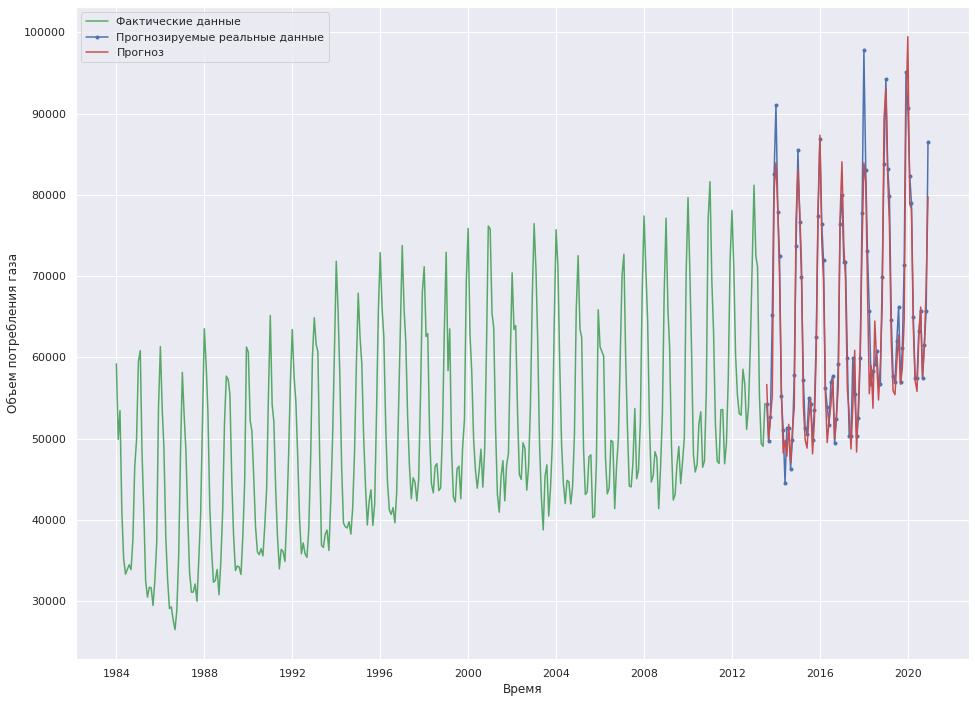

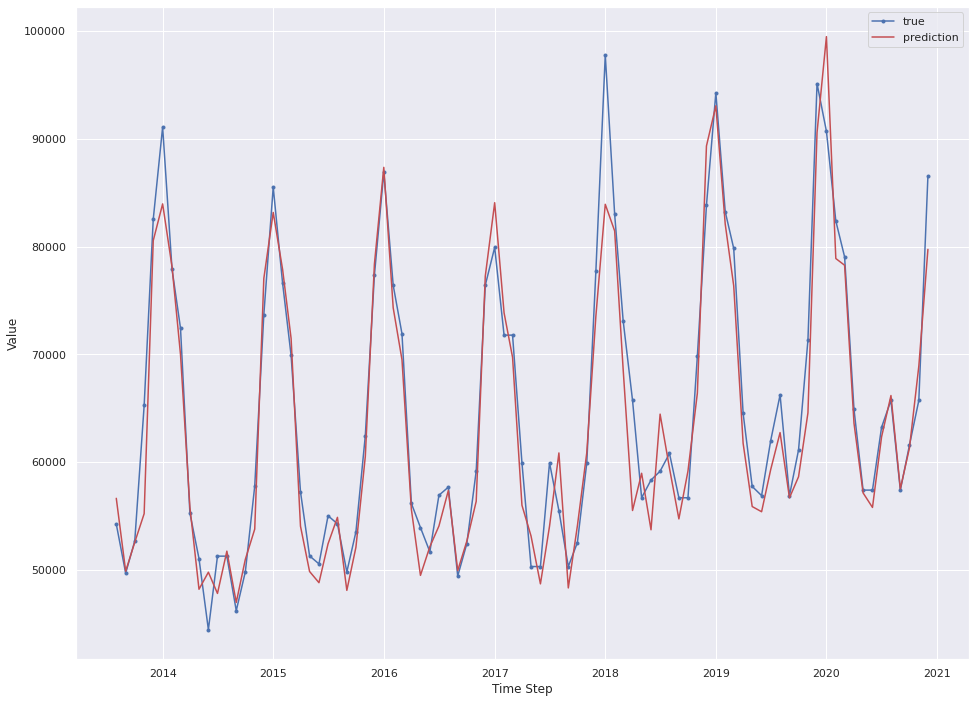

In [68]:
results = forecast(model)

In [69]:
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print('MAPE:', tf.keras.metrics.mean_absolute_percentage_error(x_valid, results).numpy())

MAE: 2684.3762
MAPE: 4.0581937


In [ ]:
# tf.keras.backend.clear_session()
# model = tf.keras.models.Sequential([
#  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
#  strides=1, padding='causal',
#  activation='relu',
#  input_shape=[None, 1]),
#  tf.keras.layers.LSTM(32, return_sequences=True),
#  tf.keras.layers.LSTM(32, return_sequences=True),
#  tf.keras.layers.Dense(30, activation='relu'),
#  tf.keras.layers.Dense(10, activation='relu'),
#  tf.keras.layers.Dense(1),
# ])
# model.summary()

In [134]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels  
    
    def plot(self, model=None, plot_col='target', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Target')    
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds     
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
        self._example = result
        return result    

In [215]:
data = pd.DataFrame({
    'target': df['USA'],
    'month_sin': month_sin,
    'month_cos': month_cos
})
data = data.set_index(df.index)

column_indices = {name: i for i, name in enumerate(data.columns)}

# column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(data)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]


train_df = data[:split_index]
test_data = data[split_index:]

num_features = data.shape[1]

w1 = WindowGenerator(input_width=24, 
                     label_width=1, 
                     shift=1,
                     train_df=train_df,
                     test_df=test_data,
                     label_columns=['target'])

In [139]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)
# w1.example = example_inputs, example_labels

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 25, 3)
Inputs shape: (3, 24, 3)
labels shape: (3, 1, 1)


In [140]:
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['target']

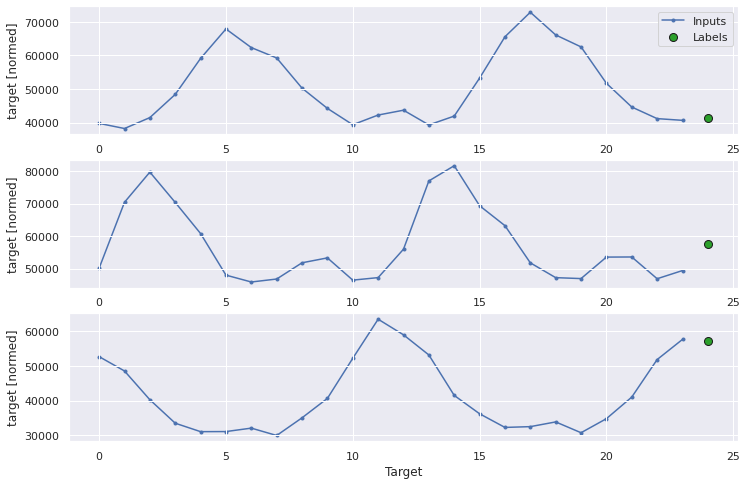

In [143]:
w1.plot()

In [145]:
w1.train.element_spec

(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [147]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [149]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,
    test_df=test_data,
    label_columns=['target'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['target']

In [150]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [156]:
baseline = Baseline(label_index=column_indices['target'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

# val_performance = {}
performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.test)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 81784032.0000 - mean_absolute_error: 7402.9341


In [158]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df,
    test_df=test_data,
    label_columns=['target'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['target']

In [159]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


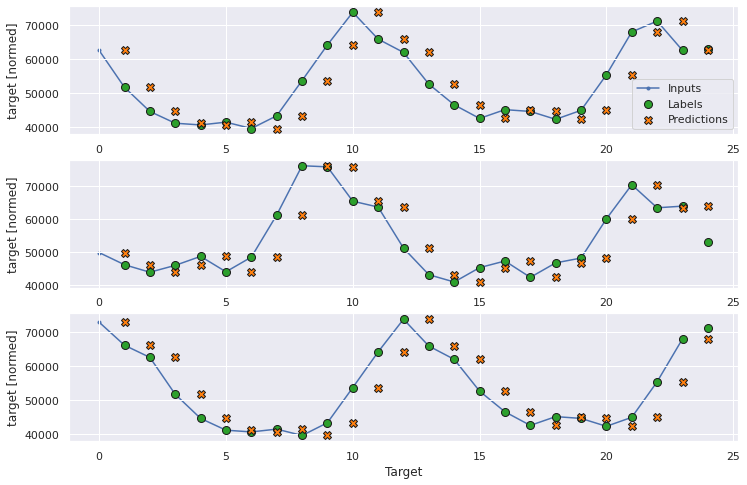

In [160]:
wide_window.plot(baseline)

In [161]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [162]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 3)
Output shape: (32, 1, 1)


In [177]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
    return history

In [171]:
history = compile_and_fit(linear, single_step_window)

# val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=1)

Epoch 1/500
12/12 [==============================] - 0s 17ms/step - loss: 185862707.6923 - mean_absolute_error: 11743.8368 - val_loss: 301394592.0000 - val_mean_absolute_error: 15025.0967
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 175676147.6923 - mean_absolute_error: 11382.3458 - val_loss: 279209536.0000 - val_mean_absolute_error: 14288.2100
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 159973547.0769 - mean_absolute_error: 10644.3287 - val_loss: 258586624.0000 - val_mean_absolute_error: 13577.4531
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 157750974.7692 - mean_absolute_error: 10322.9423 - val_loss: 239855056.0000 - val_mean_absolute_error: 12893.9844
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 145440054.1538 - mean_absolute_error: 9951.3935 - val_loss: 222389456.0000 - val_mean_absolute_error: 12236.3096
Epoch 6/500
12/12 [==============================] - 0s 10ms/st

12/12 [==============================] - 0s 10ms/step - loss: 47154037.2308 - mean_absolute_error: 5498.2180 - val_loss: 86780664.0000 - val_mean_absolute_error: 7538.5811
Epoch 46/500
3/3 [==============================] - 0s 2ms/step - loss: 86770080.0000 - mean_absolute_error: 7538.6987


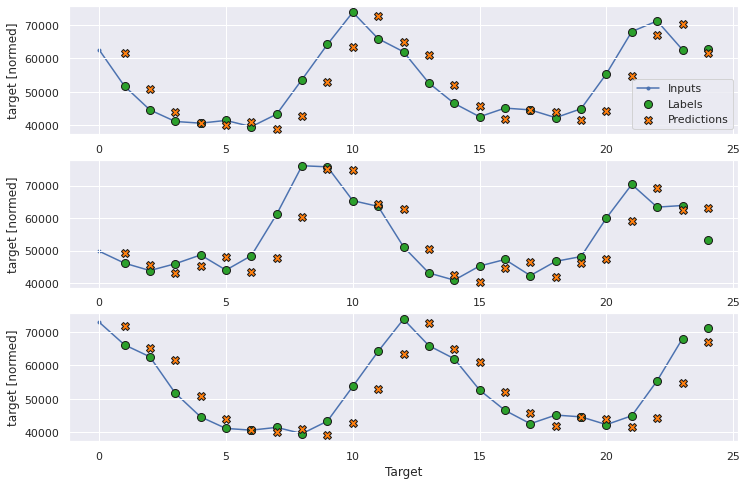

In [172]:
wide_window.plot(linear)

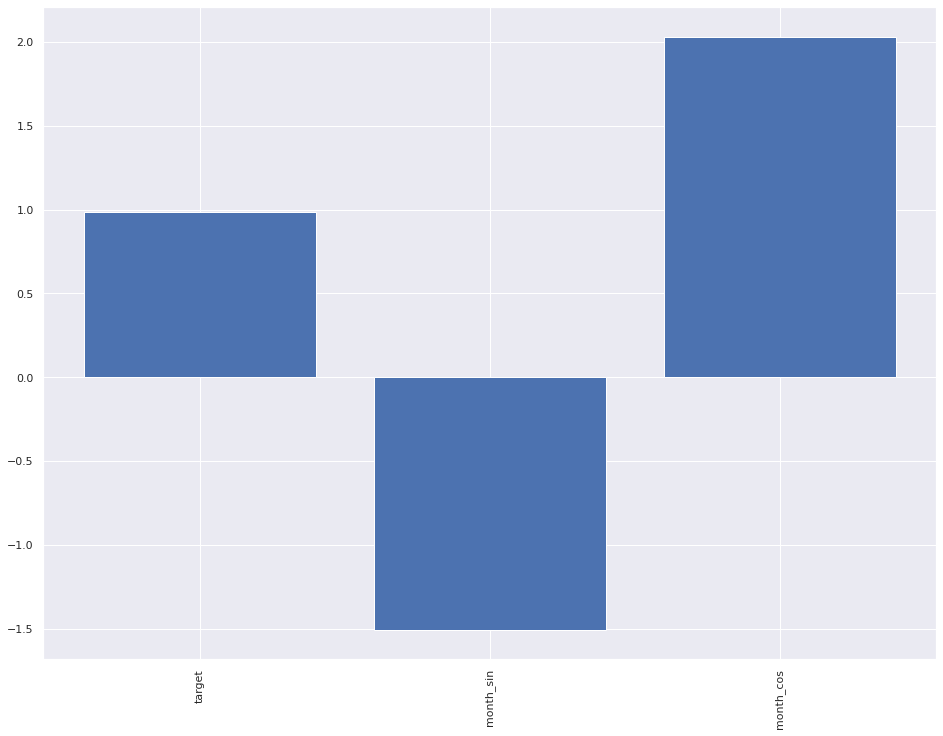

In [173]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


In [178]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

# val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=1)

Epoch 1/500
12/12 [==============================] - 1s 22ms/step - loss: 2461147273.8462 - mean_absolute_error: 48183.4736 - val_loss: 2432129280.0000 - val_mean_absolute_error: 48129.4102
Epoch 2/500
12/12 [==============================] - 0s 9ms/step - loss: 1278656019.6923 - mean_absolute_error: 34358.4474 - val_loss: 1067993856.0000 - val_mean_absolute_error: 31355.6016
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 541111931.0769 - mean_absolute_error: 21768.1068 - val_loss: 378374368.0000 - val_mean_absolute_error: 17386.3301
Epoch 4/500
12/12 [==============================] - 0s 9ms/step - loss: 159594023.3846 - mean_absolute_error: 10576.1824 - val_loss: 115385632.0000 - val_mean_absolute_error: 8147.9609
Epoch 5/500
12/12 [==============================] - 0s 10ms/step - loss: 57901607.0769 - mean_absolute_error: 5950.6620 - val_loss: 88296320.0000 - val_mean_absolute_error: 7729.6714
Epoch 6/500
12/12 [==============================] - 0s 9ms/ste

12/12 [==============================] - 0s 11ms/step - loss: 51830604.0000 - mean_absolute_error: 5700.1194 - val_loss: 89747400.0000 - val_mean_absolute_error: 7563.3843
Epoch 46/500
12/12 [==============================] - 0s 10ms/step - loss: 50784853.8462 - mean_absolute_error: 5700.9872 - val_loss: 86457824.0000 - val_mean_absolute_error: 7548.5796
Epoch 47/500
12/12 [==============================] - 0s 10ms/step - loss: 49961738.7692 - mean_absolute_error: 5626.3645 - val_loss: 86754272.0000 - val_mean_absolute_error: 7619.3218
Epoch 48/500
12/12 [==============================] - 0s 9ms/step - loss: 52678850.7692 - mean_absolute_error: 5826.6500 - val_loss: 87779728.0000 - val_mean_absolute_error: 7548.8716
Epoch 49/500
12/12 [==============================] - 0s 10ms/step - loss: 56460471.0769 - mean_absolute_error: 6015.5160 - val_loss: 87815096.0000 - val_mean_absolute_error: 7549.1802
Epoch 50/500
12/12 [==============================] - 0s 9ms/step - loss: 55854270.1538 -

12/12 [==============================] - 0s 10ms/step - loss: 50702130.7692 - mean_absolute_error: 5650.1153 - val_loss: 88577376.0000 - val_mean_absolute_error: 7554.6768
Epoch 90/500
12/12 [==============================] - 0s 10ms/step - loss: 52731342.4615 - mean_absolute_error: 5907.6869 - val_loss: 86844632.0000 - val_mean_absolute_error: 7537.2705
Epoch 91/500
12/12 [==============================] - 0s 10ms/step - loss: 53161753.5385 - mean_absolute_error: 5885.2959 - val_loss: 86362728.0000 - val_mean_absolute_error: 7551.5864
Epoch 92/500
12/12 [==============================] - 0s 9ms/step - loss: 52573127.6923 - mean_absolute_error: 5850.7427 - val_loss: 86378640.0000 - val_mean_absolute_error: 7567.3501
Epoch 93/500
12/12 [==============================] - 0s 9ms/step - loss: 53168078.7692 - mean_absolute_error: 5859.9658 - val_loss: 87243512.0000 - val_mean_absolute_error: 7542.5059
Epoch 94/500
12/12 [==============================] - 0s 10ms/step - loss: 50560120.9231 -

12/12 [==============================] - 0s 11ms/step - loss: 51836340.6154 - mean_absolute_error: 5811.3630 - val_loss: 86802376.0000 - val_mean_absolute_error: 7535.9707
Epoch 134/500
12/12 [==============================] - 0s 13ms/step - loss: 50854001.5385 - mean_absolute_error: 5705.1841 - val_loss: 87641144.0000 - val_mean_absolute_error: 7545.9575
Epoch 135/500
12/12 [==============================] - 0s 11ms/step - loss: 49409857.8462 - mean_absolute_error: 5666.4858 - val_loss: 86350096.0000 - val_mean_absolute_error: 7565.9839
Epoch 136/500
12/12 [==============================] - 0s 10ms/step - loss: 52259020.6154 - mean_absolute_error: 5760.7775 - val_loss: 86765960.0000 - val_mean_absolute_error: 7535.4067
Epoch 137/500
12/12 [==============================] - 0s 10ms/step - loss: 53492777.2308 - mean_absolute_error: 5821.7361 - val_loss: 86643888.0000 - val_mean_absolute_error: 7537.1592
Epoch 138/500
12/12 [==============================] - 0s 11ms/step - loss: 54445114

12/12 [==============================] - 0s 10ms/step - loss: 56949604.9231 - mean_absolute_error: 6032.0892 - val_loss: 87685528.0000 - val_mean_absolute_error: 7545.5498
Epoch 178/500
12/12 [==============================] - 0s 9ms/step - loss: 52869342.7692 - mean_absolute_error: 5913.7637 - val_loss: 86275480.0000 - val_mean_absolute_error: 7552.7778
Epoch 179/500
12/12 [==============================] - 0s 9ms/step - loss: 51419767.3846 - mean_absolute_error: 5731.7553 - val_loss: 86991328.0000 - val_mean_absolute_error: 7537.9141
Epoch 180/500
12/12 [==============================] - 0s 10ms/step - loss: 51464676.9231 - mean_absolute_error: 5714.0031 - val_loss: 86867192.0000 - val_mean_absolute_error: 7536.1948
Epoch 181/500
12/12 [==============================] - 0s 9ms/step - loss: 50991575.6923 - mean_absolute_error: 5649.5584 - val_loss: 86701408.0000 - val_mean_absolute_error: 7618.1948
Epoch 182/500
12/12 [==============================] - 0s 11ms/step - loss: 53079425.53

12/12 [==============================] - 0s 10ms/step - loss: 52488908.0000 - mean_absolute_error: 5715.3556 - val_loss: 87216312.0000 - val_mean_absolute_error: 7539.9263
Epoch 222/500
12/12 [==============================] - 0s 10ms/step - loss: 53037504.9231 - mean_absolute_error: 5733.7945 - val_loss: 86258176.0000 - val_mean_absolute_error: 7550.2642
Epoch 223/500
12/12 [==============================] - 0s 9ms/step - loss: 55249233.8462 - mean_absolute_error: 5916.5590 - val_loss: 87427432.0000 - val_mean_absolute_error: 7542.1636
Epoch 224/500
12/12 [==============================] - 0s 10ms/step - loss: 53704836.0000 - mean_absolute_error: 5737.2366 - val_loss: 86755872.0000 - val_mean_absolute_error: 7533.8408
Epoch 225/500
12/12 [==============================] - 0s 9ms/step - loss: 57278435.6923 - mean_absolute_error: 6038.7723 - val_loss: 86401720.0000 - val_mean_absolute_error: 7582.7583
Epoch 226/500
12/12 [==============================] - 0s 9ms/step - loss: 51614494.15

12/12 [==============================] - 0s 12ms/step - loss: 51536384.6154 - mean_absolute_error: 5875.3143 - val_loss: 86268576.0000 - val_mean_absolute_error: 7545.7104
Epoch 266/500
12/12 [==============================] - 0s 11ms/step - loss: 52815616.0000 - mean_absolute_error: 5844.0355 - val_loss: 86929320.0000 - val_mean_absolute_error: 7535.6284
Epoch 267/500
12/12 [==============================] - 0s 11ms/step - loss: 50732852.6154 - mean_absolute_error: 5764.5974 - val_loss: 86232776.0000 - val_mean_absolute_error: 7559.1079
Epoch 268/500
12/12 [==============================] - 0s 9ms/step - loss: 50015791.3846 - mean_absolute_error: 5675.9005 - val_loss: 86258104.0000 - val_mean_absolute_error: 7546.2661
Epoch 269/500
12/12 [==============================] - 0s 9ms/step - loss: 54298665.2308 - mean_absolute_error: 6032.6388 - val_loss: 86594760.0000 - val_mean_absolute_error: 7532.5220
Epoch 270/500
12/12 [==============================] - 0s 11ms/step - loss: 49771201.5

12/12 [==============================] - 0s 9ms/step - loss: 54162408.3077 - mean_absolute_error: 5862.9052 - val_loss: 86697248.0000 - val_mean_absolute_error: 7531.5874
Epoch 310/500
12/12 [==============================] - 0s 9ms/step - loss: 50407513.5385 - mean_absolute_error: 5624.5772 - val_loss: 87569096.0000 - val_mean_absolute_error: 7541.8921
Epoch 311/500
12/12 [==============================] - 0s 10ms/step - loss: 49230001.8462 - mean_absolute_error: 5545.0351 - val_loss: 86994296.0000 - val_mean_absolute_error: 7646.0552
Epoch 312/500
12/12 [==============================] - 0s 10ms/step - loss: 53828237.8462 - mean_absolute_error: 5818.4986 - val_loss: 88779440.0000 - val_mean_absolute_error: 7551.5830
Epoch 313/500
12/12 [==============================] - 0s 9ms/step - loss: 54899873.8462 - mean_absolute_error: 5868.8970 - val_loss: 87198920.0000 - val_mean_absolute_error: 7660.3955
Epoch 314/500
12/12 [==============================] - 0s 8ms/step - loss: 57930134.153

12/12 [==============================] - 0s 9ms/step - loss: 50902200.0000 - mean_absolute_error: 5763.1308 - val_loss: 86288480.0000 - val_mean_absolute_error: 7539.1636
Epoch 354/500
12/12 [==============================] - 0s 9ms/step - loss: 50610846.4615 - mean_absolute_error: 5731.1701 - val_loss: 86495336.0000 - val_mean_absolute_error: 7531.5894
Epoch 355/500
12/12 [==============================] - 0s 10ms/step - loss: 52445442.4615 - mean_absolute_error: 5842.1982 - val_loss: 86411032.0000 - val_mean_absolute_error: 7591.7285
Epoch 356/500
12/12 [==============================] - 0s 9ms/step - loss: 52643698.4615 - mean_absolute_error: 5872.0091 - val_loss: 87861888.0000 - val_mean_absolute_error: 7543.7114
Epoch 357/500
12/12 [==============================] - 0s 9ms/step - loss: 53173924.9231 - mean_absolute_error: 5845.1358 - val_loss: 86239352.0000 - val_mean_absolute_error: 7563.0640
Epoch 358/500
12/12 [==============================] - 0s 10ms/step - loss: 54358389.846

12/12 [==============================] - 0s 11ms/step - loss: 50833114.4615 - mean_absolute_error: 5674.7903 - val_loss: 86284192.0000 - val_mean_absolute_error: 7536.7798
Epoch 398/500
12/12 [==============================] - 0s 11ms/step - loss: 50842034.1538 - mean_absolute_error: 5672.0636 - val_loss: 86395528.0000 - val_mean_absolute_error: 7532.5298
Epoch 399/500
12/12 [==============================] - 0s 9ms/step - loss: 49792414.1538 - mean_absolute_error: 5621.0278 - val_loss: 86542168.0000 - val_mean_absolute_error: 7528.5483
Epoch 400/500
12/12 [==============================] - 0s 11ms/step - loss: 54517609.2308 - mean_absolute_error: 5911.3403 - val_loss: 86796408.0000 - val_mean_absolute_error: 7632.1533
Epoch 401/500
12/12 [==============================] - 0s 9ms/step - loss: 51914397.2308 - mean_absolute_error: 5794.0841 - val_loss: 86371984.0000 - val_mean_absolute_error: 7533.1777
Epoch 402/500
12/12 [==============================] - 0s 10ms/step - loss: 50398179.0

12/12 [==============================] - 0s 10ms/step - loss: 50347537.8462 - mean_absolute_error: 5701.6024 - val_loss: 86110056.0000 - val_mean_absolute_error: 7545.7690
Epoch 442/500
12/12 [==============================] - 0s 10ms/step - loss: 50204272.0000 - mean_absolute_error: 5721.2977 - val_loss: 86964688.0000 - val_mean_absolute_error: 7532.9888
Epoch 443/500
12/12 [==============================] - 0s 10ms/step - loss: 55464672.3077 - mean_absolute_error: 5836.8850 - val_loss: 87402872.0000 - val_mean_absolute_error: 7537.7231
Epoch 444/500
12/12 [==============================] - 0s 10ms/step - loss: 53964184.3077 - mean_absolute_error: 5975.0809 - val_loss: 86204552.0000 - val_mean_absolute_error: 7564.7891
Epoch 445/500
12/12 [==============================] - 0s 12ms/step - loss: 52348399.0769 - mean_absolute_error: 5779.1765 - val_loss: 86181088.0000 - val_mean_absolute_error: 7538.9771
Epoch 446/500
12/12 [==============================] - 0s 10ms/step - loss: 55044810

12/12 [==============================] - 0s 9ms/step - loss: 52297927.6923 - mean_absolute_error: 5782.8235 - val_loss: 86437408.0000 - val_mean_absolute_error: 7526.9468
Epoch 486/500
12/12 [==============================] - 0s 10ms/step - loss: 50739465.8462 - mean_absolute_error: 5616.8158 - val_loss: 86525336.0000 - val_mean_absolute_error: 7526.0654
Epoch 487/500
12/12 [==============================] - 0s 10ms/step - loss: 58068957.5385 - mean_absolute_error: 6100.5339 - val_loss: 88391128.0000 - val_mean_absolute_error: 7545.1514
Epoch 488/500
12/12 [==============================] - 0s 9ms/step - loss: 51209700.9231 - mean_absolute_error: 5717.5363 - val_loss: 86071424.0000 - val_mean_absolute_error: 7547.6270
Epoch 489/500
12/12 [==============================] - 0s 10ms/step - loss: 55829599.0769 - mean_absolute_error: 5984.6018 - val_loss: 86424224.0000 - val_mean_absolute_error: 7527.1323
Epoch 490/500
12/12 [==============================] - 0s 10ms/step - loss: 47733800.6

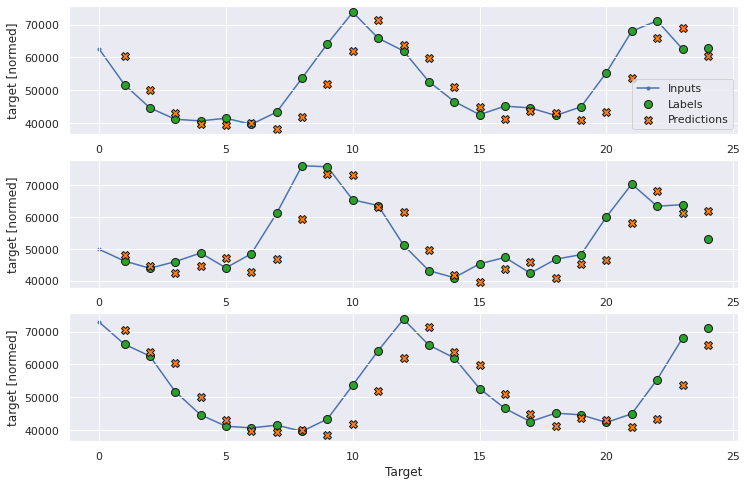

In [180]:
wide_window.plot(dense)

In [181]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df,
    test_df=test_data,
    label_columns=['target'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['target']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

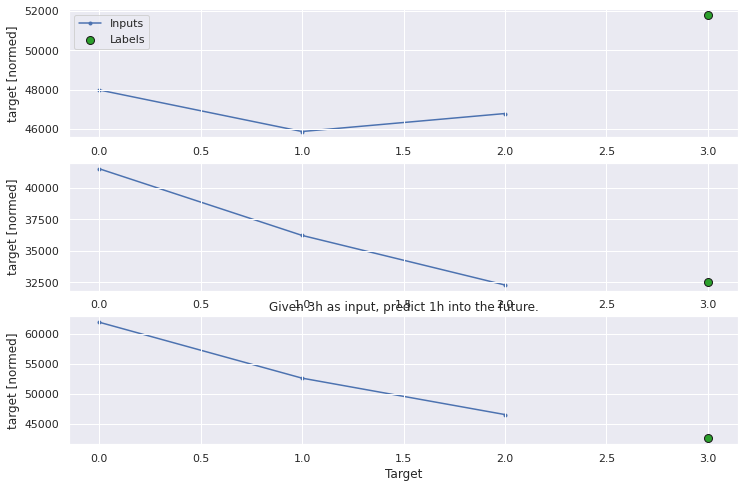

In [183]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [184]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [185]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 3)
Output shape: (32, 1, 1)


In [187]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
# val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 51496584.0000 - mean_absolute_error: 5879.6577


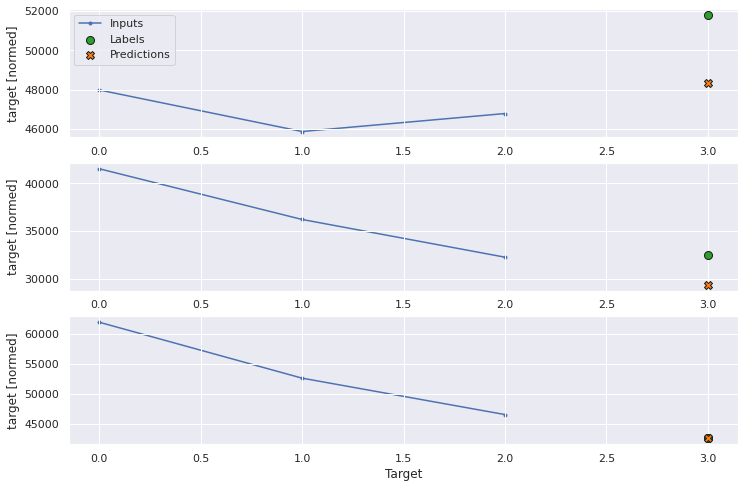

In [188]:
conv_window.plot(multi_step_dense)

In [190]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [191]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
# val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=10)

In [192]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df,
    test_df=test_data,
    label_columns=['target'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['target']

In [193]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 3)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


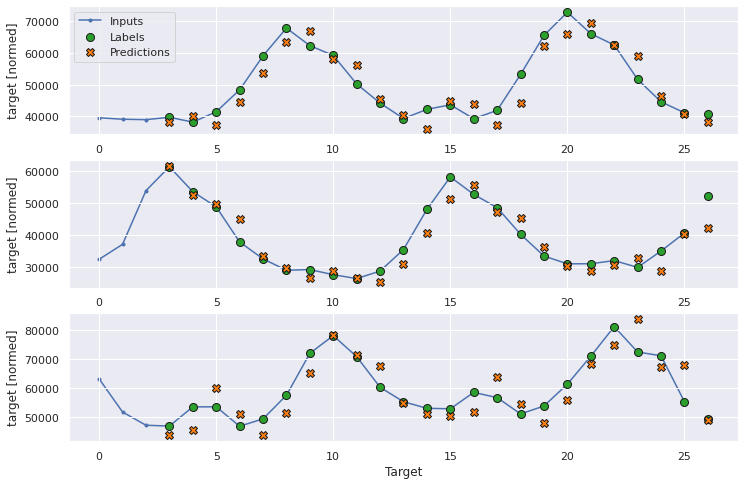

In [194]:
wide_conv_window.plot(conv_model)

In [195]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [196]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


In [198]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
# val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 4327150080.0000 - mean_absolute_error: 64523.0664


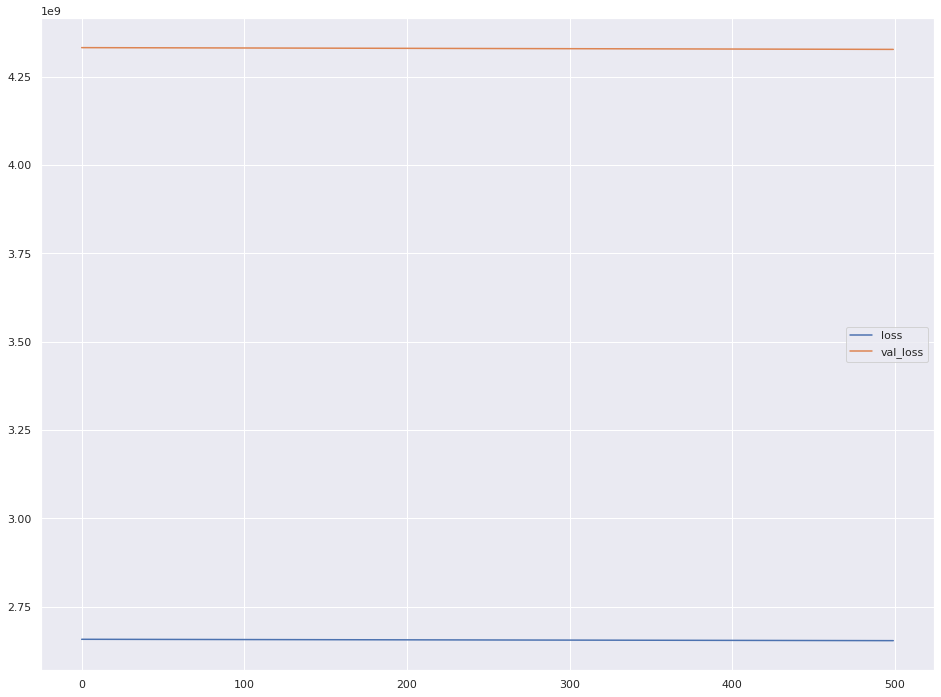

In [206]:
plot_history(history)

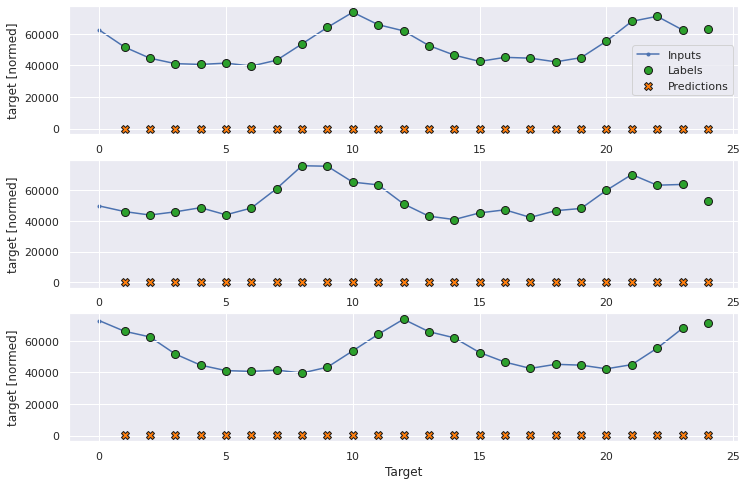

In [199]:
wide_window.plot(lstm_model)

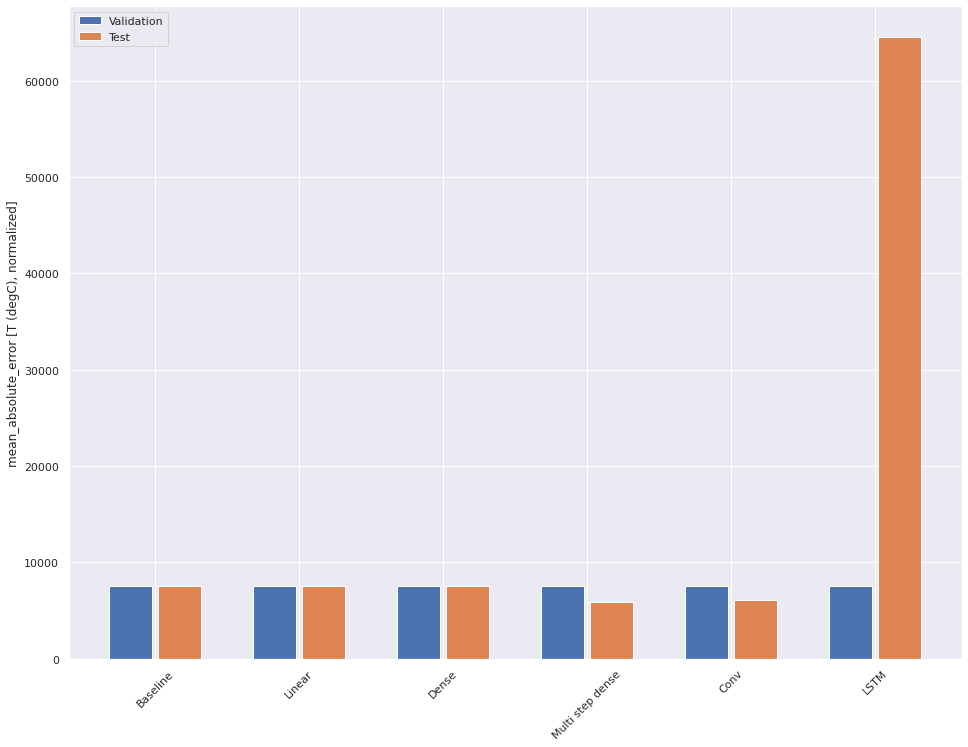

In [200]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [201]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 7570.4927
Linear      : 7538.6987
Dense       : 7553.2715
Multi step dense: 5879.6577
Conv        : 6057.3433
LSTM        : 64523.0664


# Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Label indices: [36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['target']

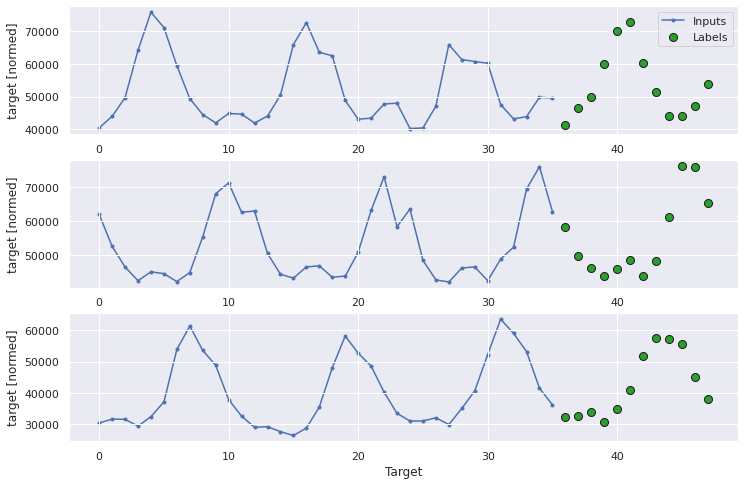

In [235]:
OUT_STEPS = 12
multi_window = WindowGenerator(input_width=36,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                              train_df=train_df,
                                test_df=test_data,
                                label_columns=['target'])

multi_window.plot()
multi_window

2/2 [==============================] - 0s 3ms/step - loss: 3235130112.0000 - mean_absolute_error: 49388.5573


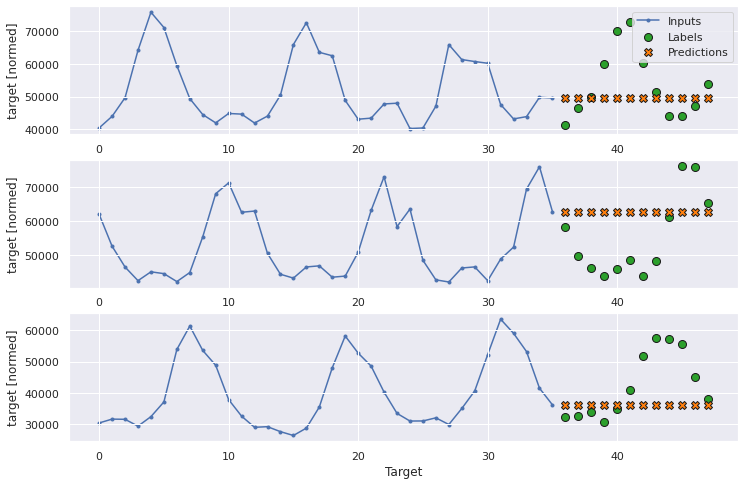

In [236]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=1)
multi_window.plot(last_baseline)

In [237]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

# multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=1)
multi_window.plot(repeat_baseline)

ValueError: in user code:

    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1185 test_step
        self.compiled_loss(
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10250 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/ab/anaconda3/envs/tf24-gpu/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 36 and 12 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](IteratorGetNext, IteratorGetNext:1)' with input shapes: [?,36,3], [?,12,1].


2/2 [==============================] - 0s 3ms/step - loss: 313246784.0000 - mean_absolute_error: 13706.8730


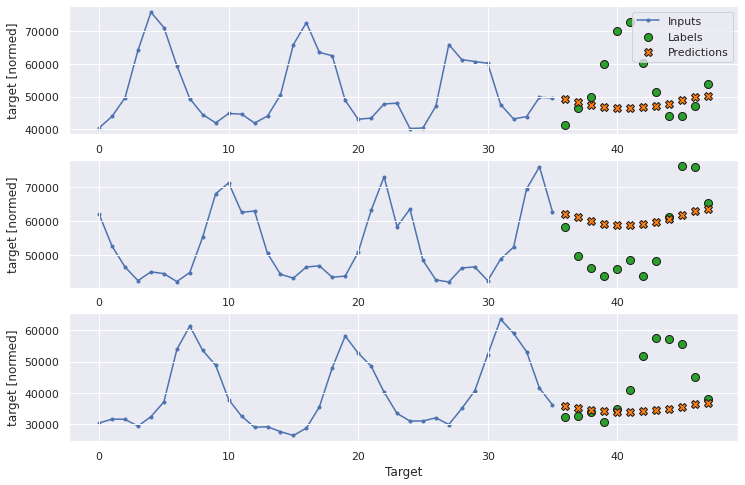

In [238]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_linear_model)

2/2 [==============================] - 0s 4ms/step - loss: 312247648.0000 - mean_absolute_error: 13690.0215


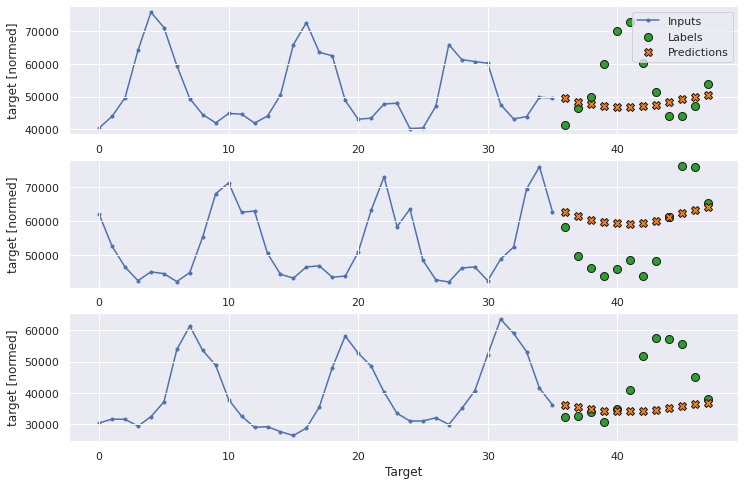

In [242]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_dense_model)

2/2 [==============================] - 0s 3ms/step - loss: 171779584.0000 - mean_absolute_error: 9518.5830


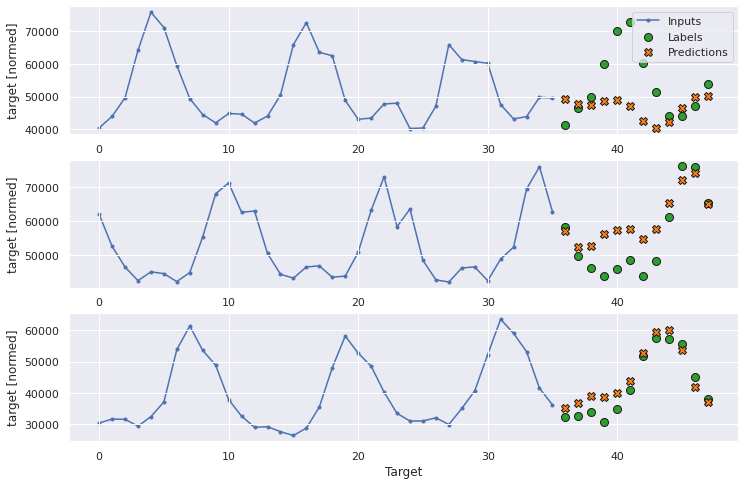

In [243]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_conv_model)

2/2 [==============================] - 0s 3ms/step - loss: 4549364736.0000 - mean_absolute_error: 66217.9219


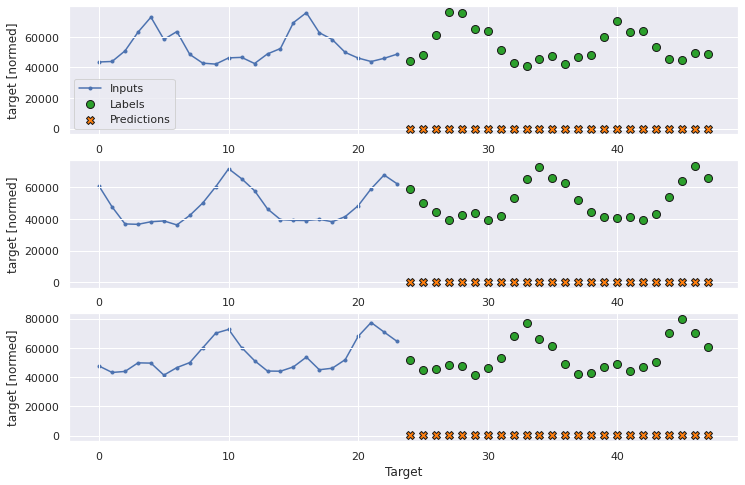

In [219]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(multi_lstm_model)

In [224]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions    

In [225]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [226]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 3])

In [227]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 3)


2/2 [==============================] - 0s 7ms/step - loss: 4531651072.0000 - mean_absolute_error: 66084.1172


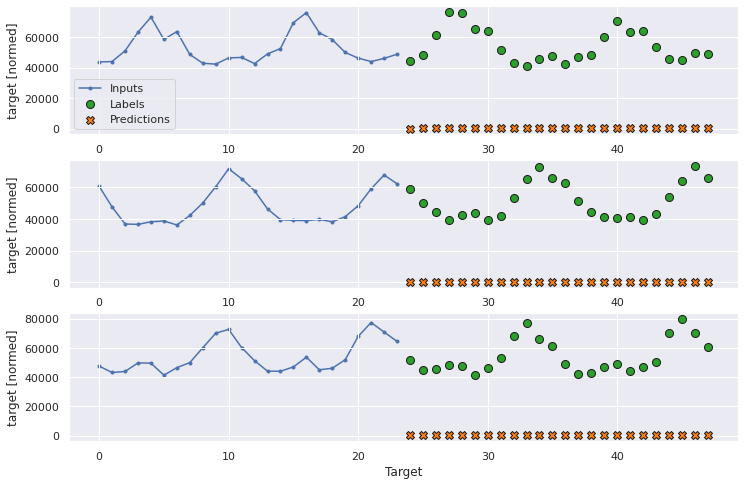

In [228]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=1)
multi_window.plot(feedback_model)

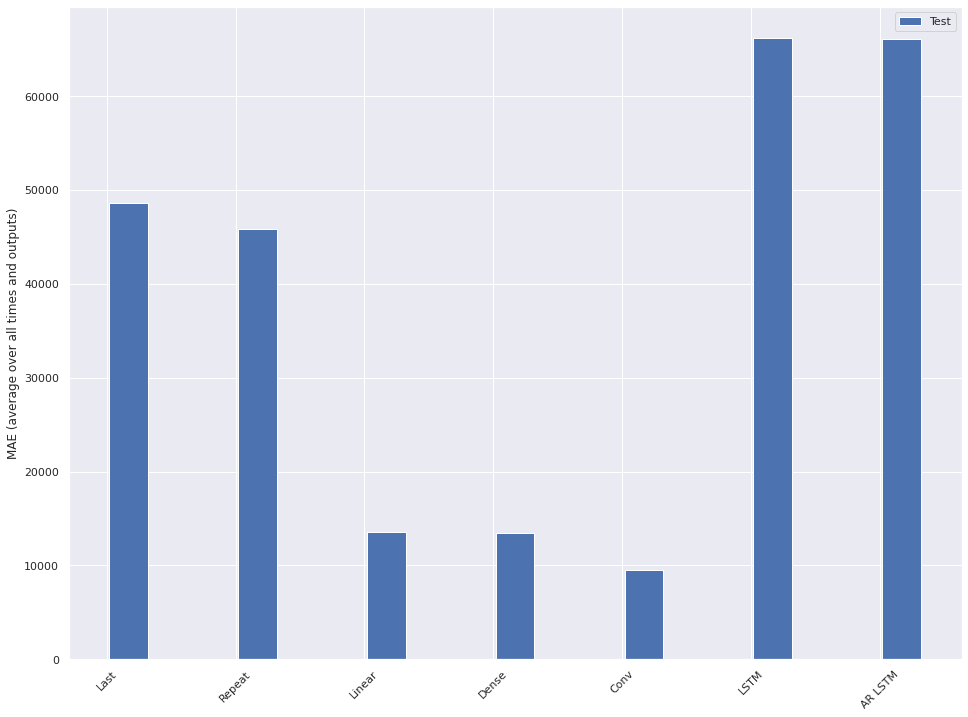

In [233]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [230]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 48674.2344
Repeat  : 45834.5039
Linear  : 13531.4961
Dense   : 13468.8350
Conv    : 9525.2461
LSTM    : 66217.9219
AR LSTM : 66084.1172
